In [1]:
library(dplyr)
library(Seurat)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject



In [2]:
library(ggplot2)
library(cowplot)


Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots




In [3]:
## remove the x-axis text and tick
## plot.margin to adjust the white space between each plot.
## ... pass any arguments to VlnPlot in Seurat
modify_vlnplot<- function(obj, 
                          feature, 
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  p<- VlnPlot(obj, features = feature, pt.size = pt.size, ... )  + 
    xlab("") + ylab(feature) + ggtitle("") + 
    theme(legend.position = "none", 
          axis.text.x = element_blank(), 
          axis.ticks.x = element_blank(), 
          axis.title.y = element_text(size = rel(1), angle = 0), 
          axis.text.y = element_text(size = rel(1)), 
          plot.margin = plot.margin ) 
  return(p)
}

## extract the max value of the y axis
extract_max<- function(p){
  ymax<- max(ggplot_build(p)$layout$panel_scales_y[[1]]$range$range)
  return(ceiling(ymax))
}


## main function
StackedVlnPlot<- function(obj, features,
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  
  plot_list<- purrr::map(features, function(x) modify_vlnplot(obj = obj,feature = x, ...))
  
  # Add back x-axis title to bottom plot. patchwork is going to support this?
  plot_list[[length(plot_list)]]<- plot_list[[length(plot_list)]] +
    theme(axis.text.x=element_text(), axis.ticks.x = element_line())
  
  # change the y-axis tick to only max value 
  ymaxs<- purrr::map_dbl(plot_list, extract_max)
  plot_list<- purrr::map2(plot_list, ymaxs, function(x,y) x + 
                            scale_y_continuous(breaks = c(y)) + 
                            expand_limits(y = y))

  p<- patchwork::wrap_plots(plotlist = plot_list, ncol = 1)
  return(p)
}

In [5]:
normal.data <- Read10X(data.dir = "/together_sdg/sc1229/newcontract/RNA3/YQF-3/YQF-3/outs/filtered_feature_bc_matrix")
normal <- CreateSeuratObject(counts = normal.data, project = "poems13", min.cells = 3, min.features = 100)

In [6]:
normal

An object of class Seurat 
20305 features across 8675 samples within 1 assay 
Active assay: RNA (20305 features, 0 variable features)

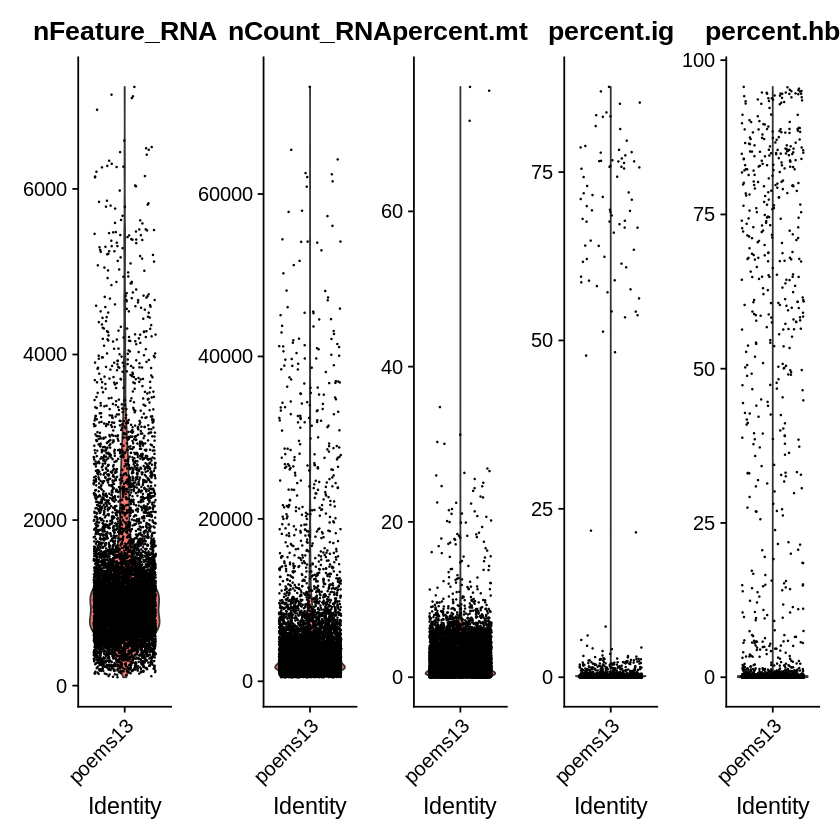

In [7]:
normal[["percent.mt"]] <- PercentageFeatureSet(normal, pattern = "^MT-")
normal[["percent.ig"]] <- PercentageFeatureSet(normal, pattern = "^IG")
normal[["percent.hb"]] <- PercentageFeatureSet(normal, pattern = "^HB")
VlnPlot(normal, features = c("nFeature_RNA", "nCount_RNA", "percent.mt","percent.ig","percent.hb"), ncol = 5)

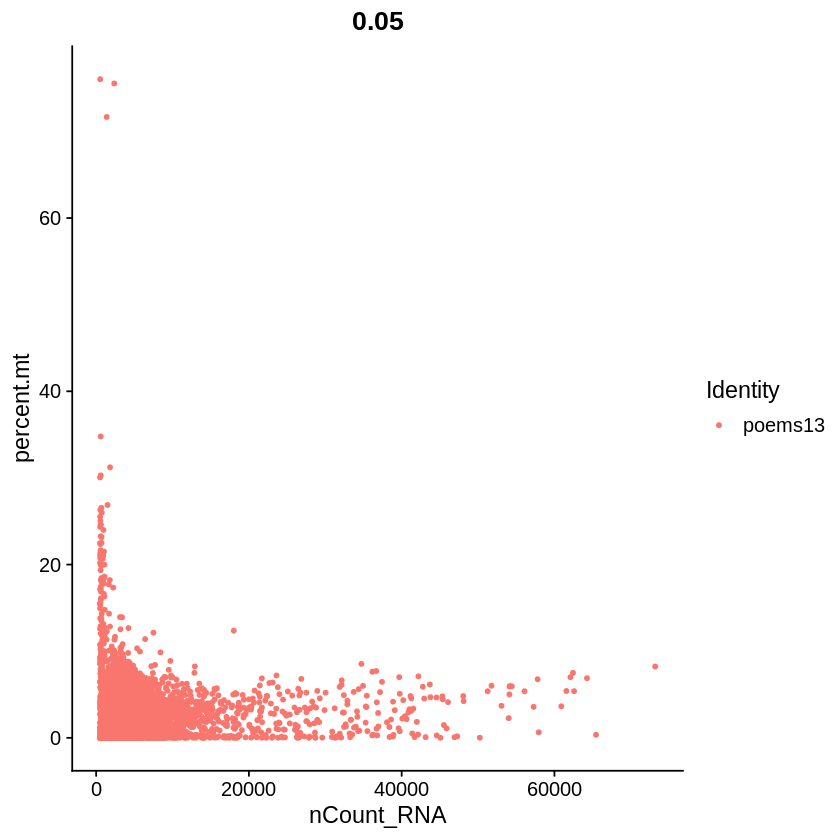

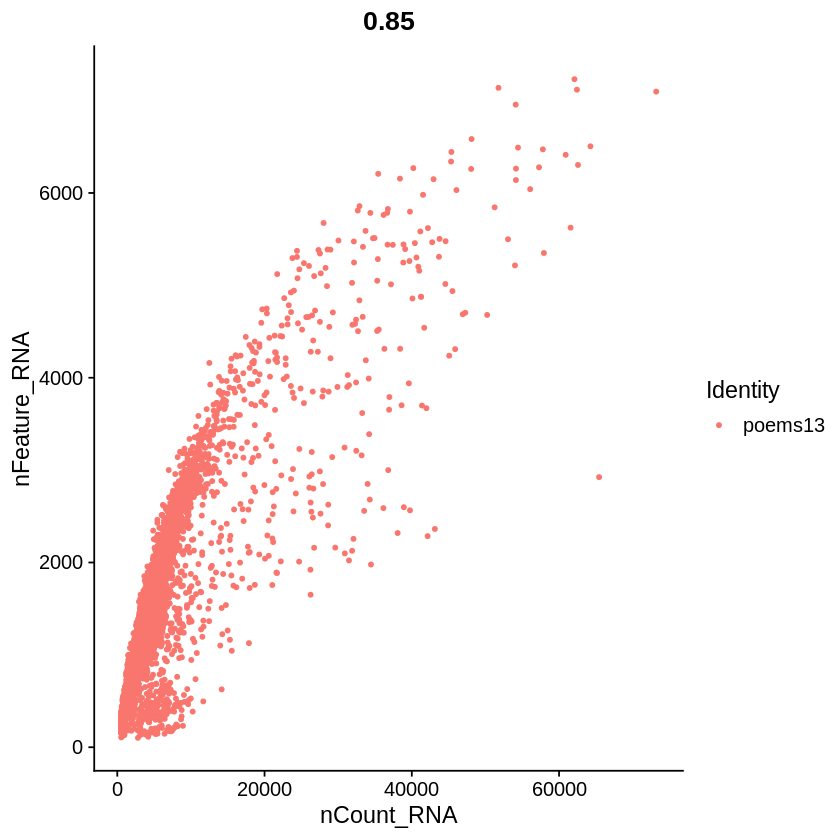

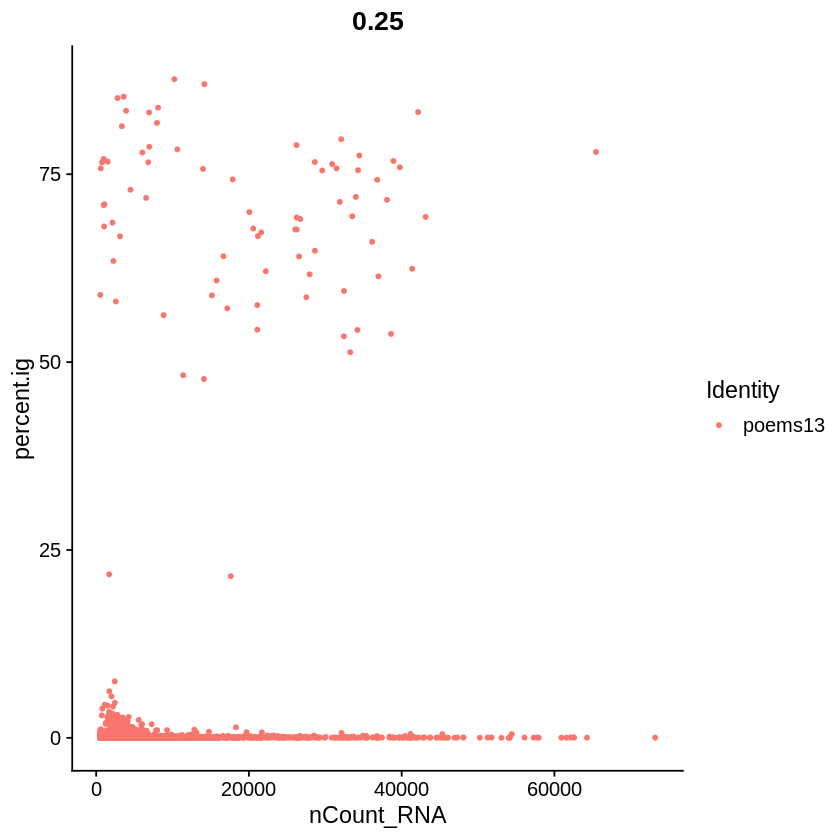

In [8]:
plot1 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot3 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "percent.ig")
plot1
plot2
plot3

In [9]:
normal <- subset(normal, subset = nFeature_RNA > 100 & nFeature_RNA < 4000 & percent.mt < 5 & percent.hb<1)
normal

An object of class Seurat 
20305 features across 7062 samples within 1 assay 
Active assay: RNA (20305 features, 0 variable features)

In [10]:
normal <- NormalizeData(normal, normalization.method = "LogNormalize", scale.factor = 10000)

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 142 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 142 rows containing missing values (geom_point).”


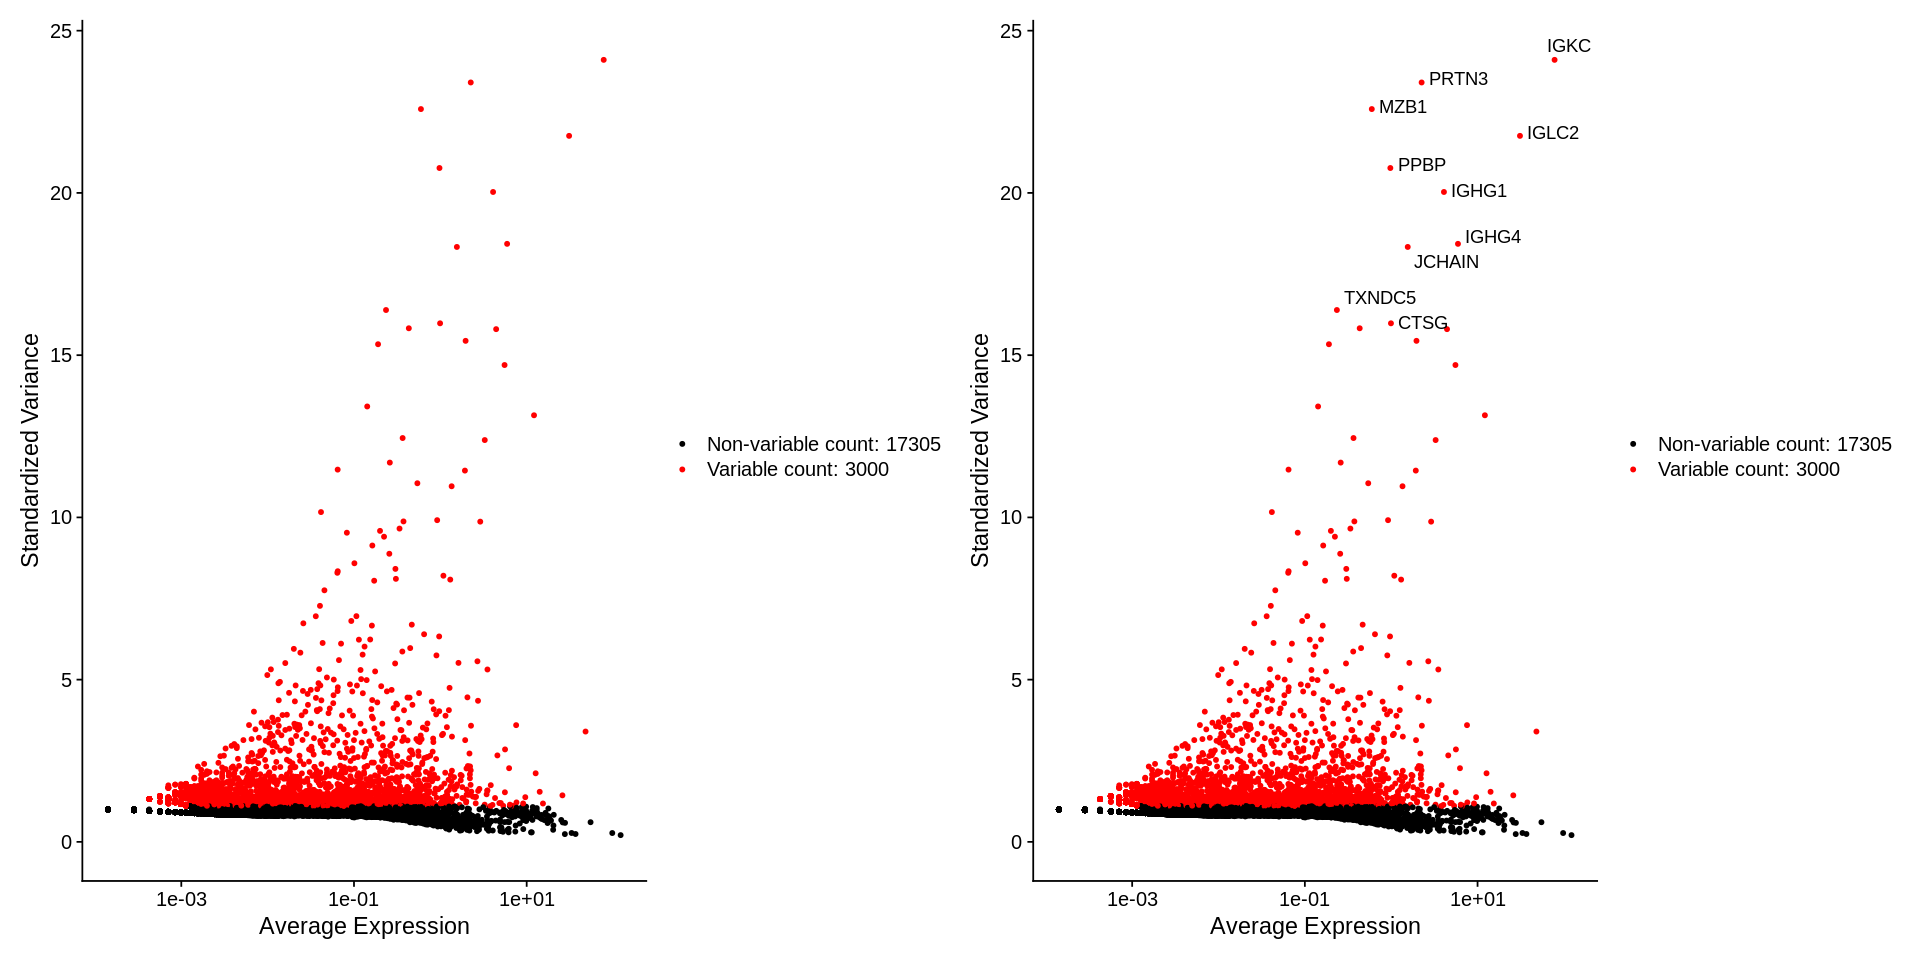

In [11]:
normal <- FindVariableFeatures(normal, selection.method = "vst", nfeatures = 3000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(normal), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(normal)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
options(repr.plot.height=8,repr.plot.width=16)
plot1+plot2

In [12]:
all.genes <- rownames(normal)
normal <- ScaleData(normal, features = all.genes)

Centering and scaling data matrix



In [13]:
length(VariableFeatures(object = normal))

[1] 3000

In [14]:
normal <- RunPCA(normal, features = VariableFeatures(object = normal))

PC_ 1 
Positive:  RPS4X, RPL10A, RPL36A, RPS2, RPS5, PTMA, RPL7A, RPL5, RPSA, EEF1B2 
	   RPLP0, PPIA, RPS17, EEF1G, CD52, S100A10, NME2, NPM1, CRIP1, SNHG6 
	   MIF, HINT1, HNRNPA1, SSR4, SLC25A6, IL32, AHNAK, LDHB, HSP90AB1, ARL4C 
Negative:  FCGR3B, G0S2, PTGS2, NAMPT, SOD2, CXCR2, CTSS, CMTM2, PGLYRP1, S100A12 
	   CXCL8, CXCR1, MMP9, VNN2, ACSL1, PADI4, AQP9, CRISP3, NABP1, GLUL 
	   STEAP4, PROK2, EGR1, TREM1, TRIB1, CLC, SERPINA1, KCNJ15, IL1R2, FFAR2 
PC_ 2 
Positive:  VCAN, CPVL, CST3, IFI30, MS4A6A, KLF4, MPEG1, MARCH1, CD36, TGFBI 
	   MAFB, CD14, CD300E, HLA-DRA, CD68, LRP1, FGL2, LY86, SLC7A7, ASGR1 
	   SHTN1, TMEM176B, ZNF385A, MS4A7, CTSB, AHR, HLA-DMB, GASK1B, CTSS, CD86 
Negative:  IL32, CD3D, CD3E, TRBC2, PCED1B-AS1, CD2, CD3G, TRAC, NKG7, BCL11B 
	   ARL4C, IL7R, TRBC1, LIME1, LCK, GZMM, GZMA, CD69, CCL5, CD24 
	   CD247, SPOCK2, PRKCQ-AS1, KLRB1, CTSW, TCF7, CST7, CEACAM8, ITM2A, LINC00861 
PC_ 3 
Positive:  IL32, CD3D, CD2, ARL4C, CD52, LTB, CD3E, CD3G, PCED1B-AS1

In [15]:
options(repr.plot.height=8,repr.plot.width=8)

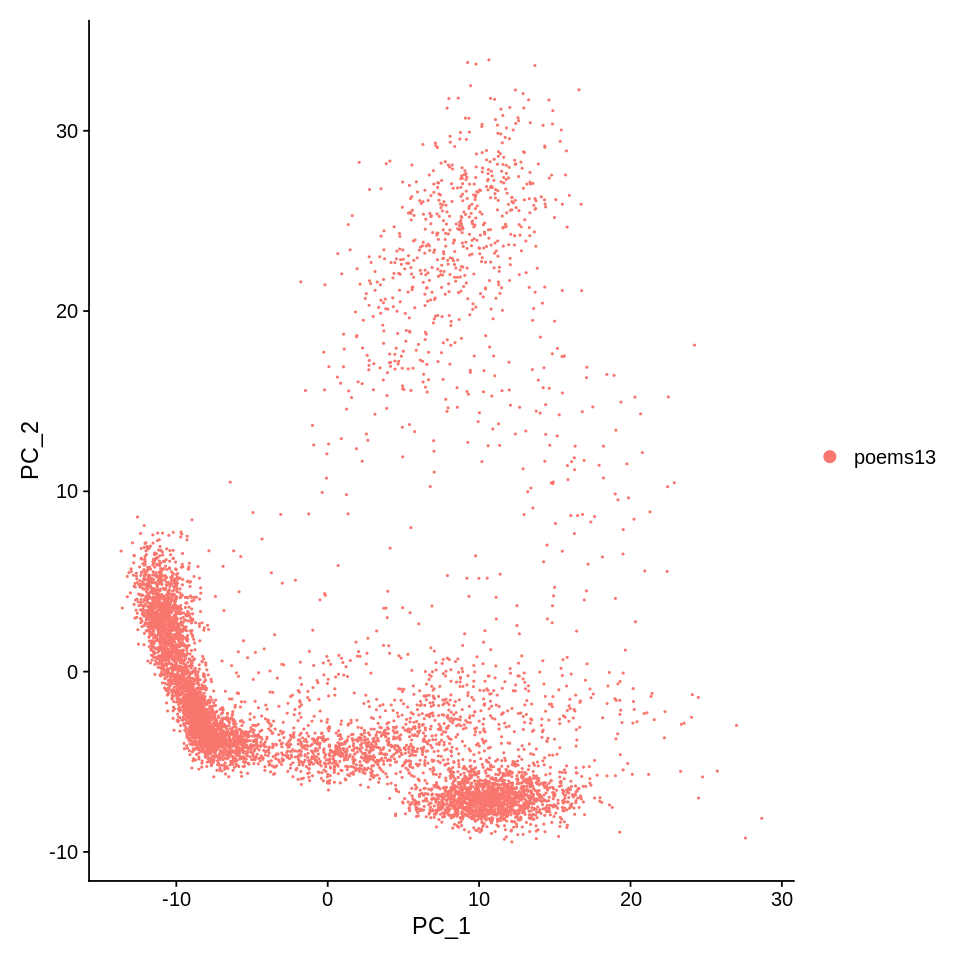

In [16]:
DimPlot(normal, reduction = "pca")

In [17]:
normal <- JackStraw(normal, num.replicate = 100)
normal <- ScoreJackStraw(normal, dims = 1:20)

Warning message:
“Removed 42000 rows containing missing values (geom_point).”


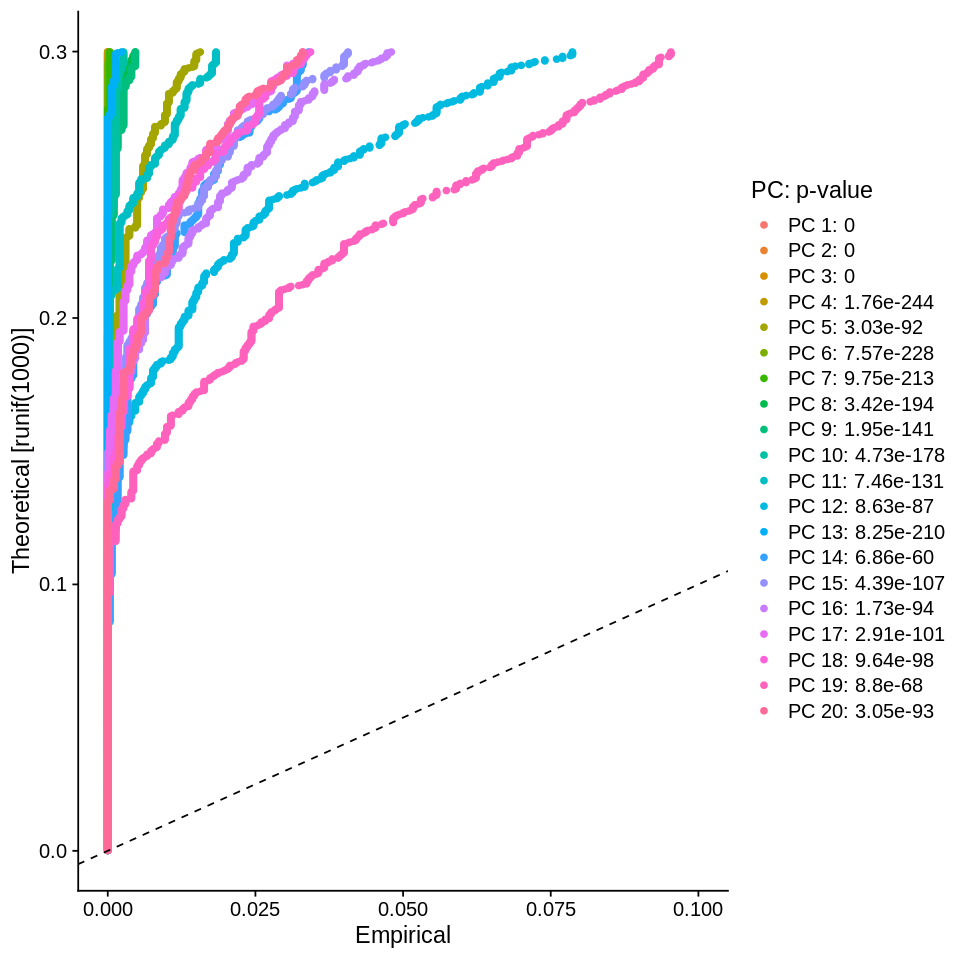

In [18]:
JackStrawPlot(normal, dims = 1:20)

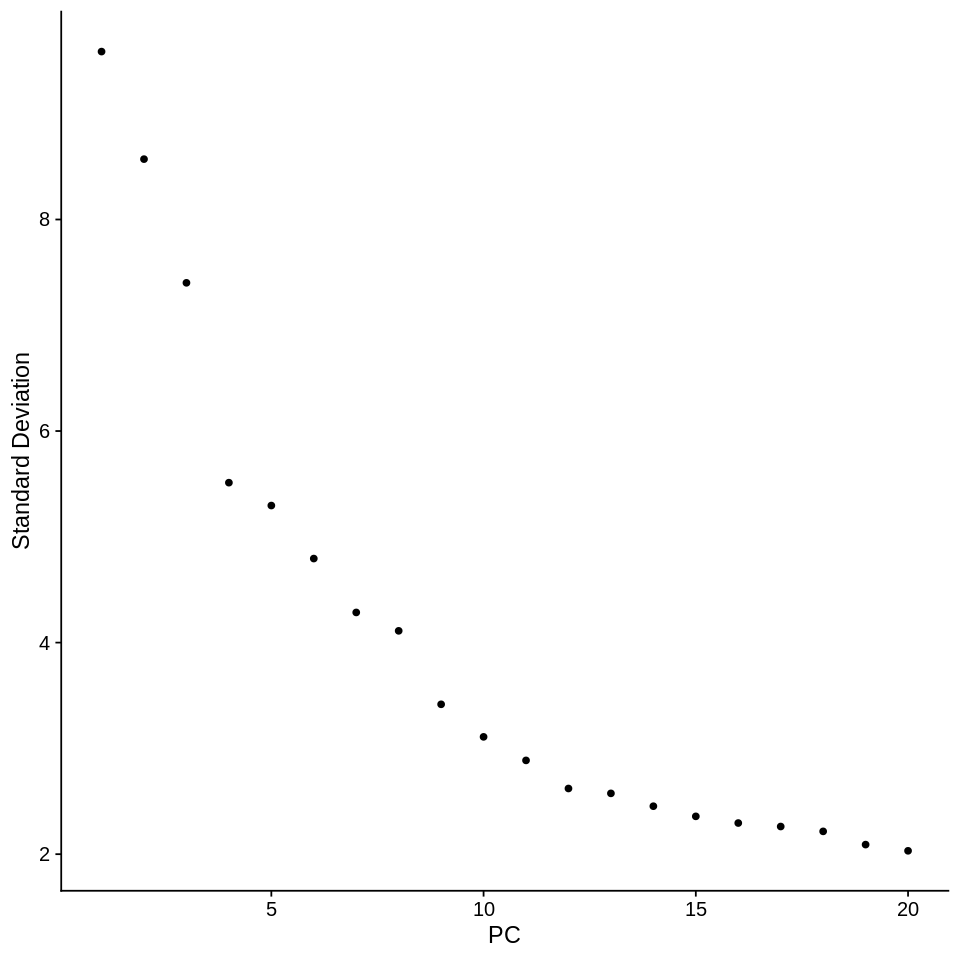

In [19]:
ElbowPlot(normal)

In [20]:
normal <- RunUMAP(normal, dims = 1:14)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
16:56:59 UMAP embedding parameters a = 0.9922 b = 1.112

16:56:59 Read 7062 rows and found 14 numeric columns

16:56:59 Using Annoy for neighbor search, n_neighbors = 30

16:56:59 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:56:59 Writing NN index file to temp file /tmp/RtmpBVQrYK/file2e0136f3989b9

16:56:59 Searching Annoy index using 1 thread, search_k = 3000

16:57:01 Annoy recall = 100%

16:57:01 Commencing smooth kNN distance calibration using 1 thread

16:57:02 Initializing fr

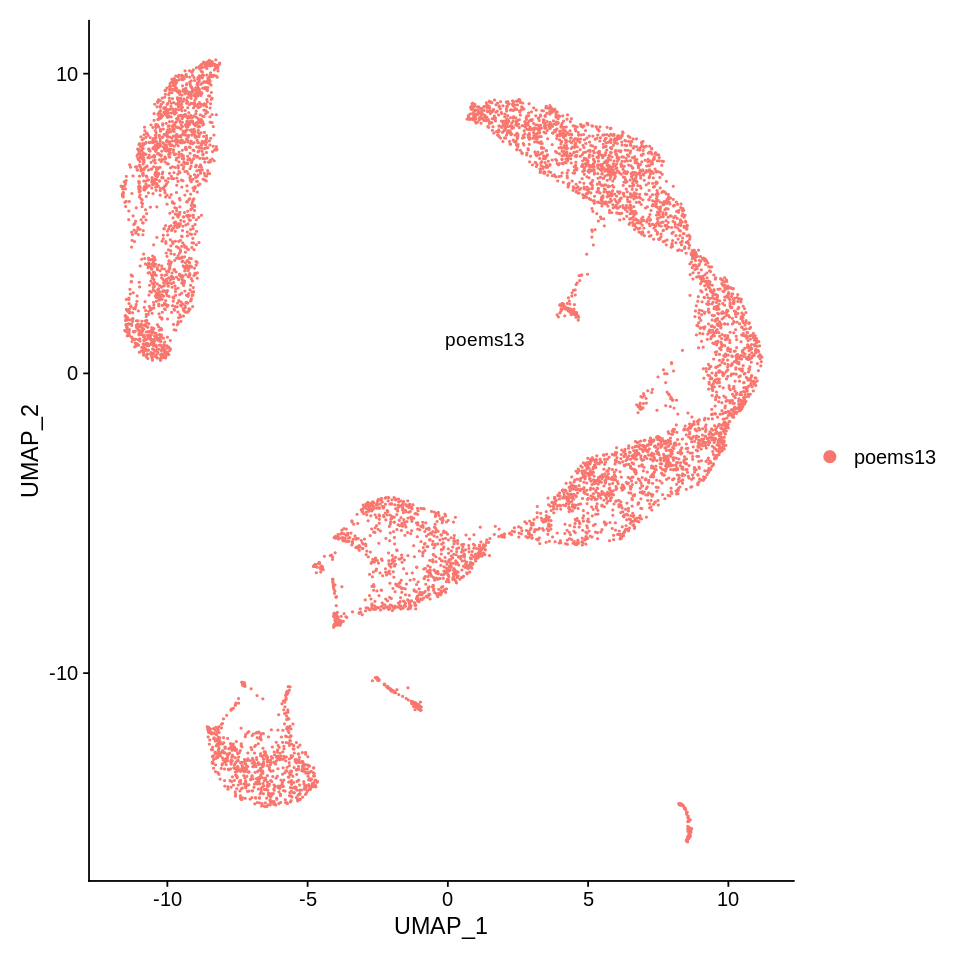

In [21]:
DimPlot(normal, reduction = "umap",label=T)

Loading required package: fields

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.7-0 (2021-06-25) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 



[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."


Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: ROCR

Loading required package: modes



NULL


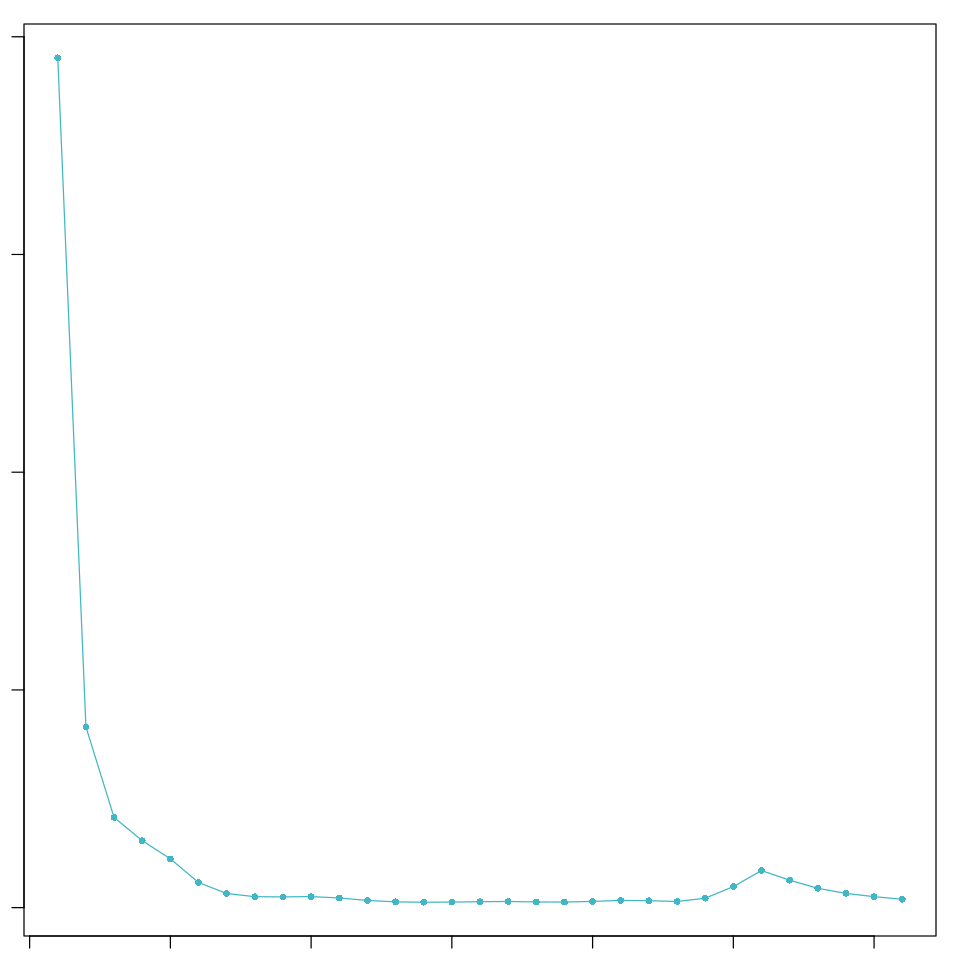

In [22]:
library(DoubletFinder)
sweep.res.list <- paramSweep_v3(normal, PCs = 1:14, sct = FALSE)
for(i in 1:length(sweep.res.list)){
  if(length(sweep.res.list[[i]]$pANN[is.nan(sweep.res.list[[i]]$pANN)]) != 0){
    if(i != 1){
      sweep.res.list[[i]] <- sweep.res.list[[i - 1]]
    }else{
      sweep.res.list[[i]] <- sweep.res.list[[i + 1]]
    }
  }
}
sweep.stats <- summarizeSweep(sweep.res.list, GT = FALSE)
bcmvn <- find.pK(sweep.stats)
pk_v <- as.numeric(as.character(bcmvn$pK))
pk_good <- pk_v[bcmvn$BCmetric==max(bcmvn$BCmetric)]
nExp_poi <- round(0.1*length(colnames(normal)))

In [23]:
normal <- doubletFinder_v3(normal, PCs = 1:14, pN = 0.25, pK = pk_good, nExp = nExp_poi, reuse.pANN = FALSE, sct = FALSE)

[1] "Creating 2354 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


In [24]:
colnames(normal@meta.data)[ncol(normal@meta.data)]="DoubletFinder"

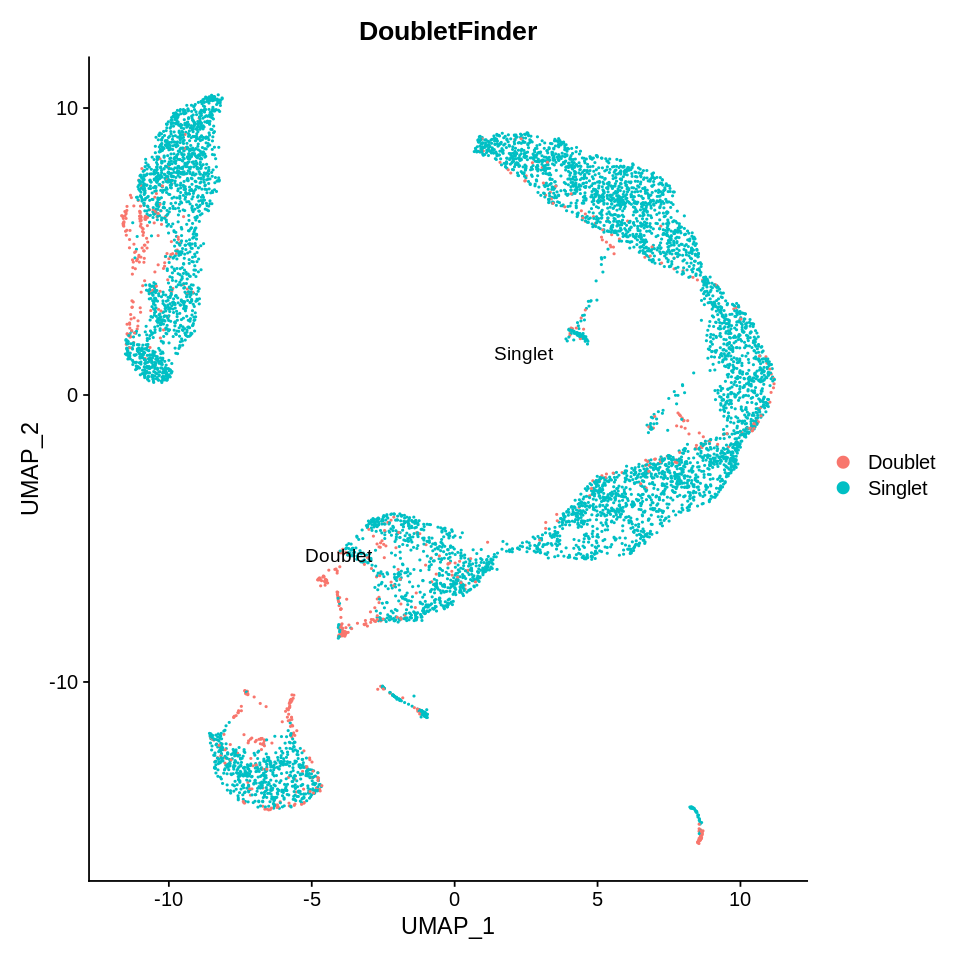

In [25]:
DimPlot(normal, reduction = "umap",label=T,group.by='DoubletFinder')

In [26]:
normal2<-subset(normal,DoubletFinder=='Singlet')

In [27]:
normal
normal2

An object of class Seurat 
20305 features across 7062 samples within 1 assay 
Active assay: RNA (20305 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
20305 features across 6356 samples within 1 assay 
Active assay: RNA (20305 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 520 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 520 rows containing missing values (geom_point).”


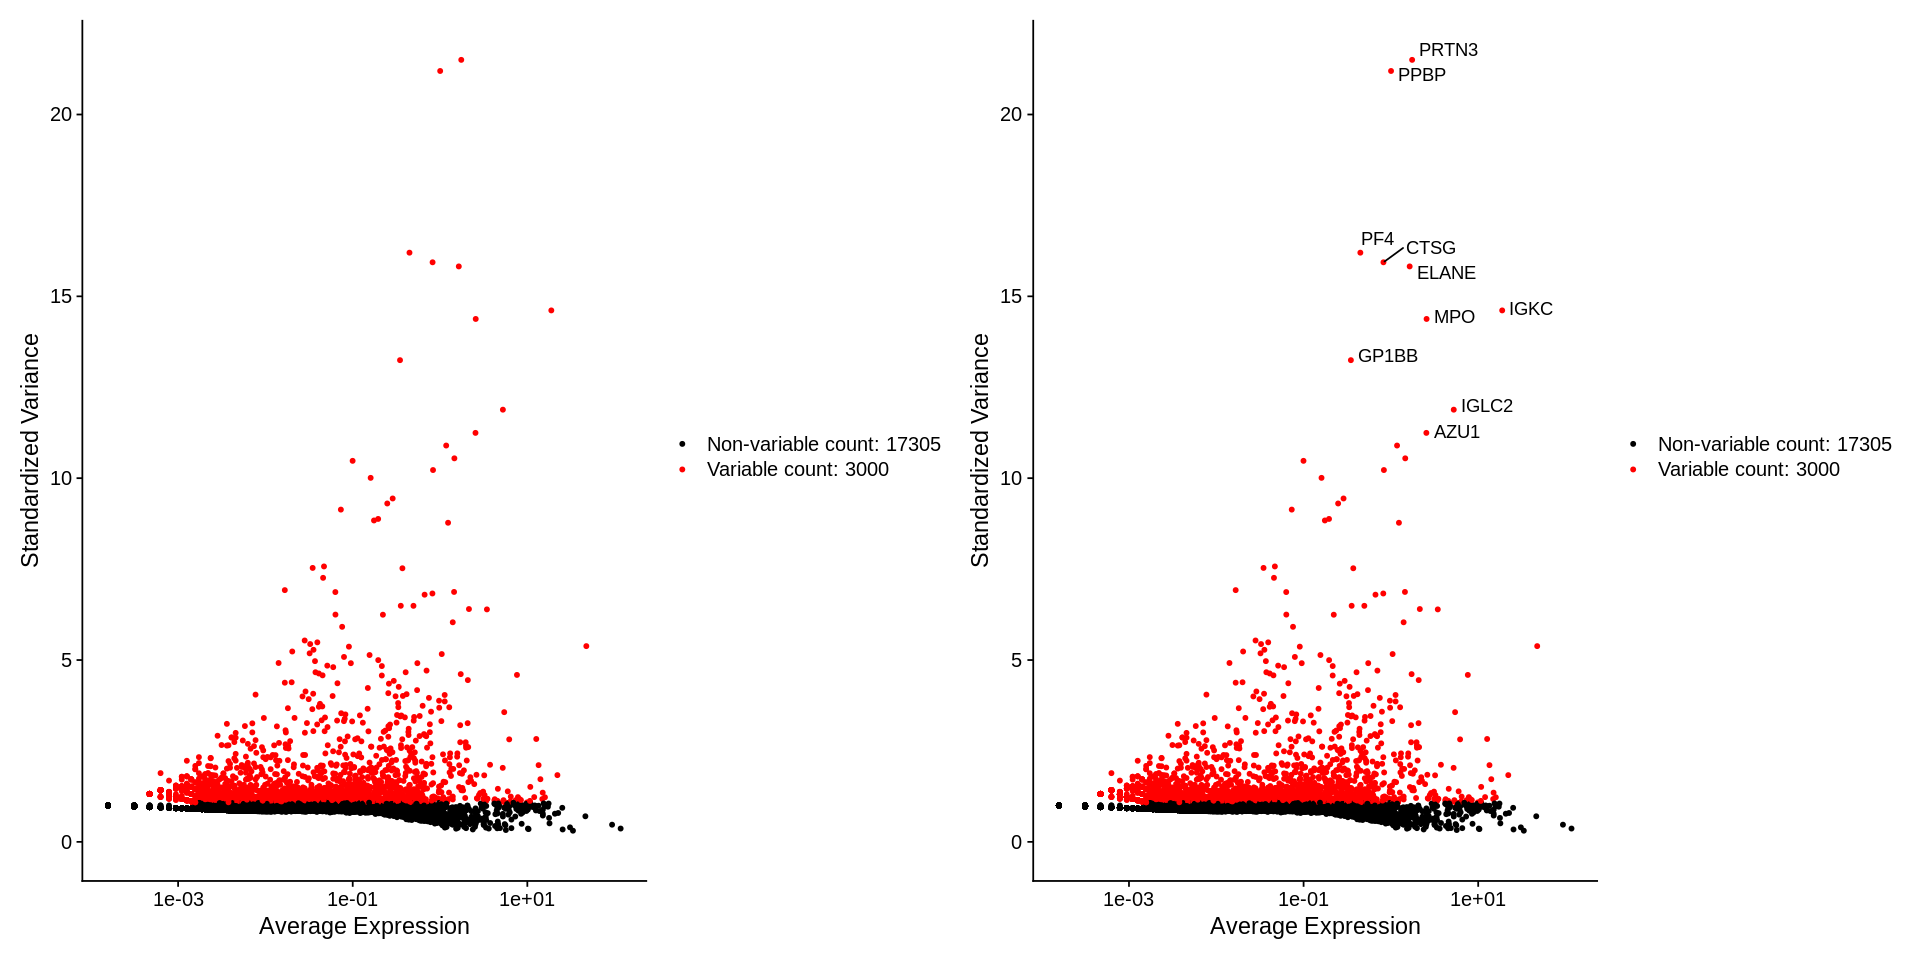

In [28]:
normal2 <- FindVariableFeatures(normal2, selection.method = "vst", nfeatures = 3000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(normal2), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(normal2)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
options(repr.plot.height=8,repr.plot.width=16)
plot1+plot2

In [29]:
all.genes <- rownames(normal2)
normal2 <- ScaleData(normal2, features = all.genes)

Centering and scaling data matrix



In [30]:
length(VariableFeatures(object = normal2))

[1] 3000

In [31]:
normal2 <- RunPCA(normal2, features = VariableFeatures(object = normal2))

PC_ 1 
Positive:  RPS4X, RPL23A, RPS18, RPL3, RPS21, RPL10A, RPS19, RPS5, RPSA, RPS2 
	   RPL36A, RPS8, RPL5, RPL11, EEF1B2, RPS16, IL32, CD52, RPLP0, CD3D 
	   ARL4C, CD2, CD3E, TRBC2, CRIP1, CD3G, RPS17, PCED1B-AS1, HINT1, TLE5 
Negative:  NAMPT, RGS2, CTSS, SOD2, G0S2, FCGR3B, PTGS2, TYROBP, SAT1, LRRK2 
	   C5AR1, CXCR2, CXCL8, FCGR2A, SERPINA1, CMTM2, TREM1, CEBPB, VNN2, GLUL 
	   FTL, AQP9, CLEC7A, ACSL1, COTL1, NABP1, IGSF6, CXCR1, S100A12, NEAT1 
PC_ 2 
Positive:  VCAN, CPVL, TGFBI, MARCH1, KLF4, MS4A6A, HLA-DRA, CD36, CD300E, MAFB 
	   HLA-DRB1, LRP1, CST3, IFI30, LY86, MPEG1, HLA-DRB5, TMEM176B, ASGR1, CD68 
	   SHTN1, CD74, HLA-DMB, AHR, SLC7A7, CD14, ADA2, LGALS2, CTSB, GASK1B 
Negative:  CD24, PGLYRP1, LCN2, CEACAM8, LTF, CAMP, CRISP3, UGCG, BPI, MMP8 
	   ARG1, CLC, SYNE1, STOM, HP, ABCA13, CPNE3, MMP9, TCN1, SERPINB10 
	   RETN, CEACAM1, PADI4, MS4A3, PLCG2, DEFA3, TTN-AS1, CD177, CHI3L1, CEBPE 
PC_ 3 
Positive:  CD24, BPI, LYZ, CEACAM8, MS4A3, RNASE2, DEFA3, DEFA4, AC02

In [32]:
normal2 <- JackStraw(normal2, num.replicate = 100)
normal2 <- ScoreJackStraw(normal2, dims = 1:20)

Warning message:
“Removed 42198 rows containing missing values (geom_point).”


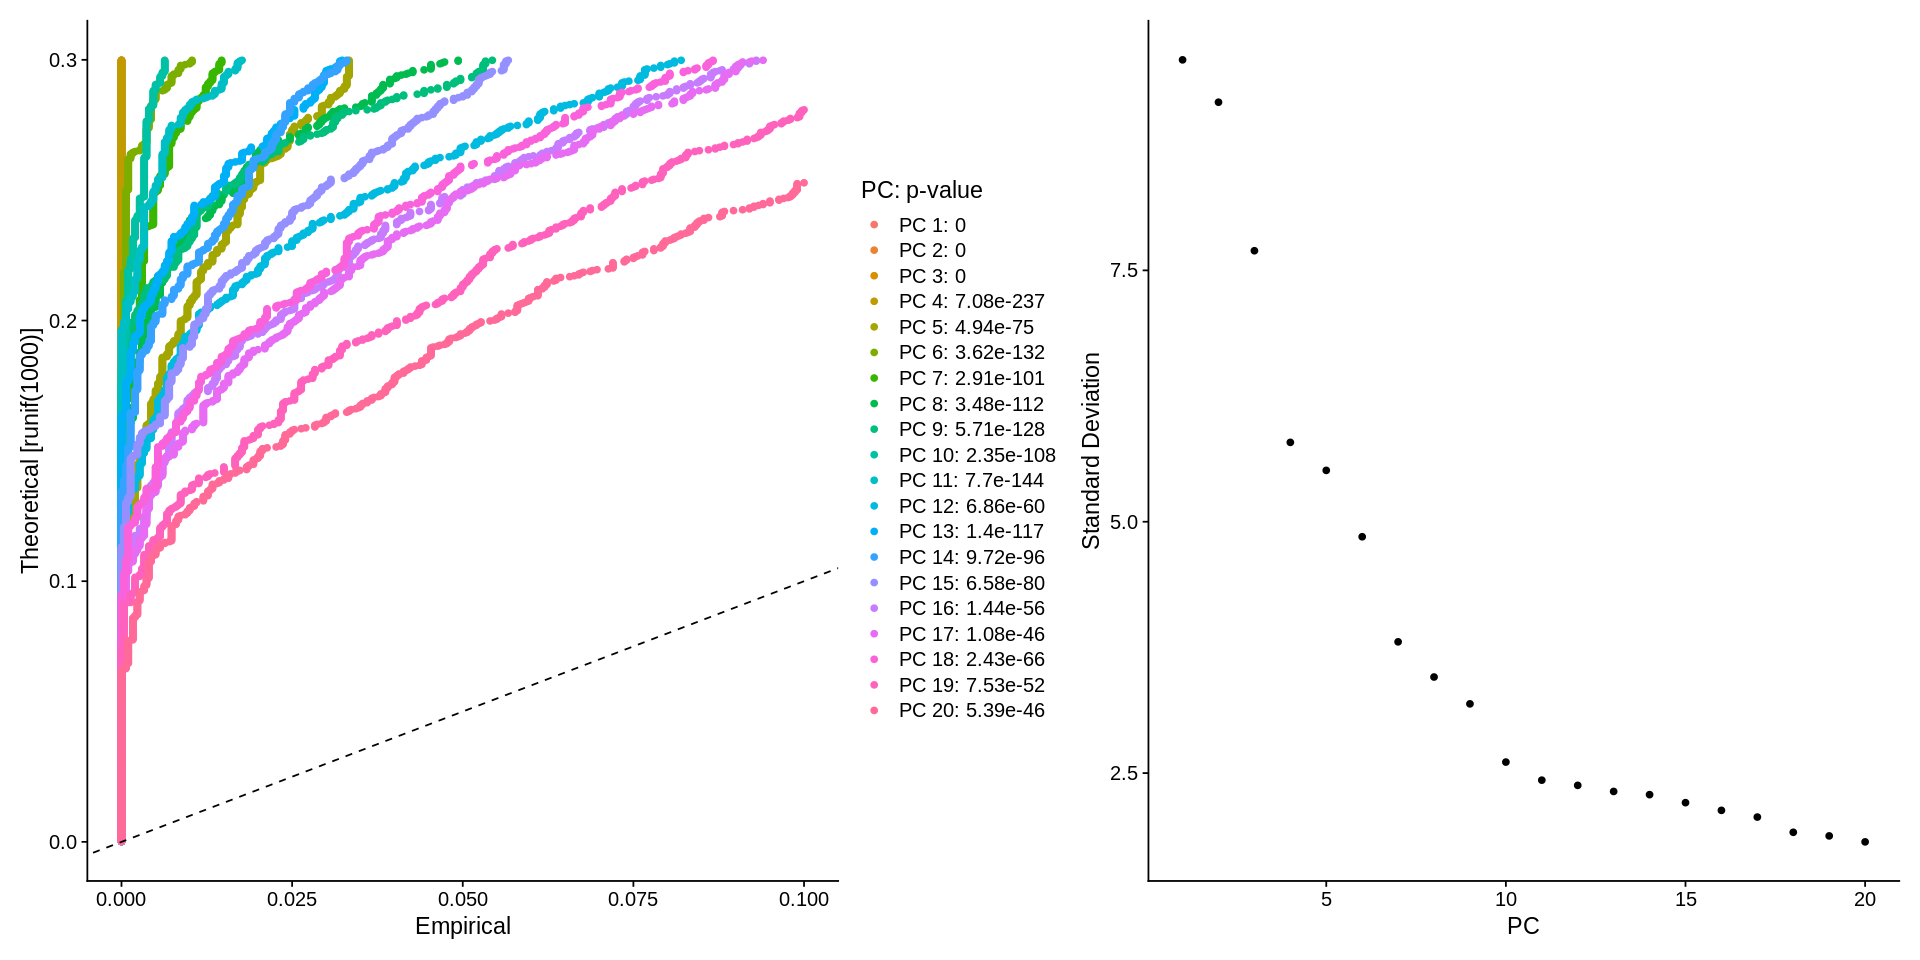

In [33]:
jplot<-JackStrawPlot(normal2, dims = 1:20)
eplot<-ElbowPlot(normal2)
options(repr.plot.height=8,repr.plot.width=16)
jplot+eplot

In [34]:
normal2 <- FindNeighbors(normal2, dims = 1:12)
normal2 <- FindClusters(normal2, resolution = 0.6)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6356
Number of edges: 216581

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9145
Number of communities: 14
Elapsed time: 0 seconds


In [35]:
normal2 <- RunUMAP(normal2, dims = 1:12)

17:03:36 UMAP embedding parameters a = 0.9922 b = 1.112

17:03:36 Read 6356 rows and found 12 numeric columns

17:03:36 Using Annoy for neighbor search, n_neighbors = 30

17:03:36 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:03:37 Writing NN index file to temp file /tmp/RtmpBVQrYK/file2e0135129b206

17:03:37 Searching Annoy index using 1 thread, search_k = 3000

17:03:39 Annoy recall = 100%

17:03:39 Commencing smooth kNN distance calibration using 1 thread

17:03:40 Initializing from normalized Laplacian + noise

17:03:41 Commencing optimization for 500 epochs, with 252362 positive edges

17:03:49 Optimization finished



In [36]:
options(repr.plot.height=8,repr.plot.width=8)

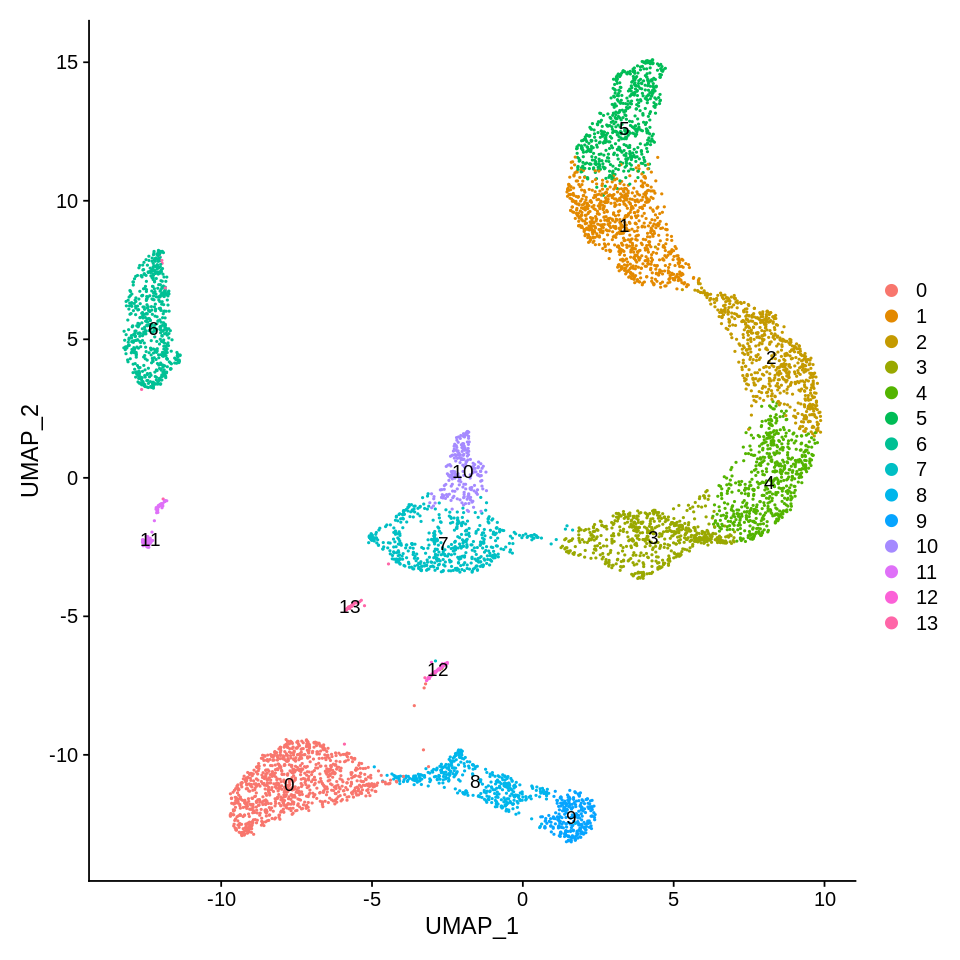

In [37]:
DimPlot(normal2, reduction = "umap",label=T)

In [38]:
load('/together_sdc/zhoujiaqi/sc0418/RNA/imgs.xxy/HPCA.Rdata')
load('/together_sdc/zhoujiaqi/sc0418/RNA/imgs.xxy/NHD.RData')
library(Seurat)
library(SingleR)
library(viridis)
library(pheatmap)

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4


Attaching package: ‘stats4’


The following object is masked from ‘package:spam’:

    mle


Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:spam’:

    cbind, rbind


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filte

In [39]:
#进行singleR注释
AL_for_SingleR <- GetAssayData(normal2, slot="data") ##获取标准化矩阵

In [40]:
#先从cluster分辨率注释
clusterann<-SingleR(AL_for_SingleR, hpca.se, method="cluster", clusters=normal2@meta.data$seurat_clusters,labels=hpca.se$label.main)
#　save(clusterann,file="/together_sdb/zhoujiaqi/sc0418/RNA/imgs.xxy/AL1.M/dim8_res0.8/clusterann.Rdata")
clusterann
clusterann<-as.data.frame(row.names=clusterann@rownames,clusterann$labels)

Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 2”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 26”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 7”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 8”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 2”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 88”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 17”
Warning message:
“Argument 'center' should be

DataFrame with 14 rows and 5 columns
                            scores     first.labels      tuning.scores
                          <matrix>      <character>        <DataFrame>
0   0.277232:0.594131:0.539074:...          T_cells 0.792879:0.7277712
1   0.131277:0.439819:0.596824:...      Neutrophils 0.665836:0.0230173
2   0.134812:0.430857:0.634939:...        Myelocyte 0.490352:0.3791467
3   0.175102:0.433020:0.652645:...        Myelocyte 0.802223:0.7120658
4   0.166926:0.428709:0.644506:...        Myelocyte 0.804643:0.7369454
...                            ...              ...                ...
9   0.278851:0.566220:0.518470:...          NK_cell  0.800468:0.718287
10  0.261582:0.471246:0.675408:...        Myelocyte  0.522617:0.215254
11  0.264070:0.695774:0.583869:...           B_cell  0.517750:0.214836
12  0.177045:0.296397:0.457057:...        Platelets  0.388668:0.119686
13  0.223447:0.442939:0.481788:... Pre-B_cell_CD34-  0.266248:0.174705
              labels    pruned.labels
  

In [41]:
AL.nhsc <- SingleR(test = AL_for_SingleR, ref= nhd.se, labels = nhd.se$label.main) 

Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 29”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 6”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 21”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 24”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 4”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 10”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 5”
Warning message:
“Argument 'center' should b

In [42]:
meta=normal2@meta.data
table(AL.nhsc$labels,meta$seurat_clusters)
normal2@meta.data$labels <-AL.nhsc$labels

                 
                    0   1   2   3   4   5   6   7   8   9  10  11  12  13
  B cells           0   0   0   0   0   0   0   0   0   0   0  69   0   6
  Basophils         0   0   0   0   0   0   0   0   0   0   0  14   0   2
  CD4+ T cells    691   0   0   0   0   0   0   0   0   0   0   0   0   0
  CD8+ T cells    243   0   0   0   0   0   0   0 347  47   0   0   0   0
  CMPs              0   0   0   0   0   0   0  43   0   0   1   0   0   6
  Dendritic cells   0   0   0   0   0   0   0   0   0   0   0   1   0   2
  Eosinophils       0   0   1   0   0   0   0   0   0   0   0   3   0   9
  Erythroid cells   0   0   0   0   0   0   0   0   0   0   1   0   0   0
  GMPs              0   0   0   0   0   0   0   9   0   0   0   0   0   0
  Granulocytes      1   6  15 111  44   7   0  82   2   0  41   1   2   4
  HSCs              0   0   0   0   0   0   0   0   0   0   0   0   0   3
  Megakaryocytes    1   0   0   0   0   0   0   0   0   0   0   0  44   1
  MEPs              

In [43]:
options(repr.plot.height=9,repr.plot.width=16)

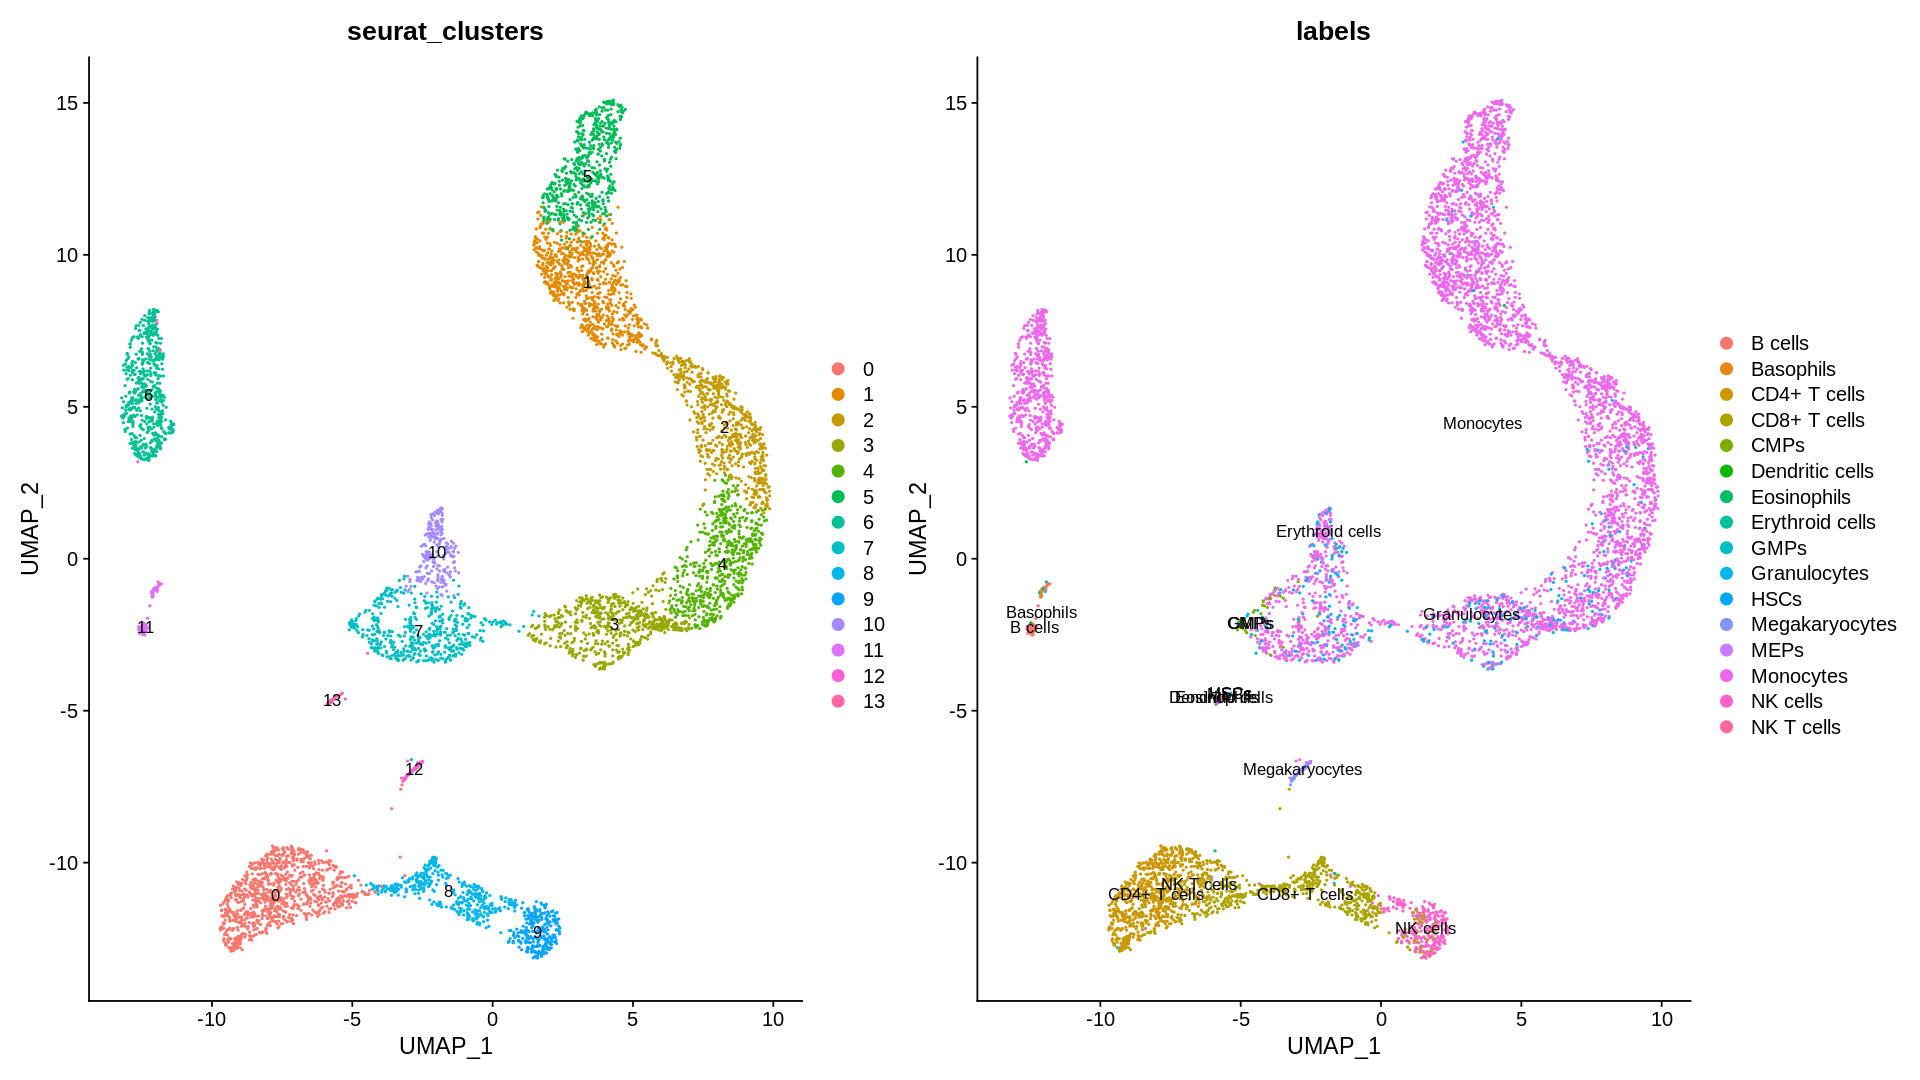

In [44]:
label_plot<-DimPlot(normal2, group.by = c("seurat_clusters","labels"),reduction = "umap",label = TRUE,label.size =3.5)
label_plot

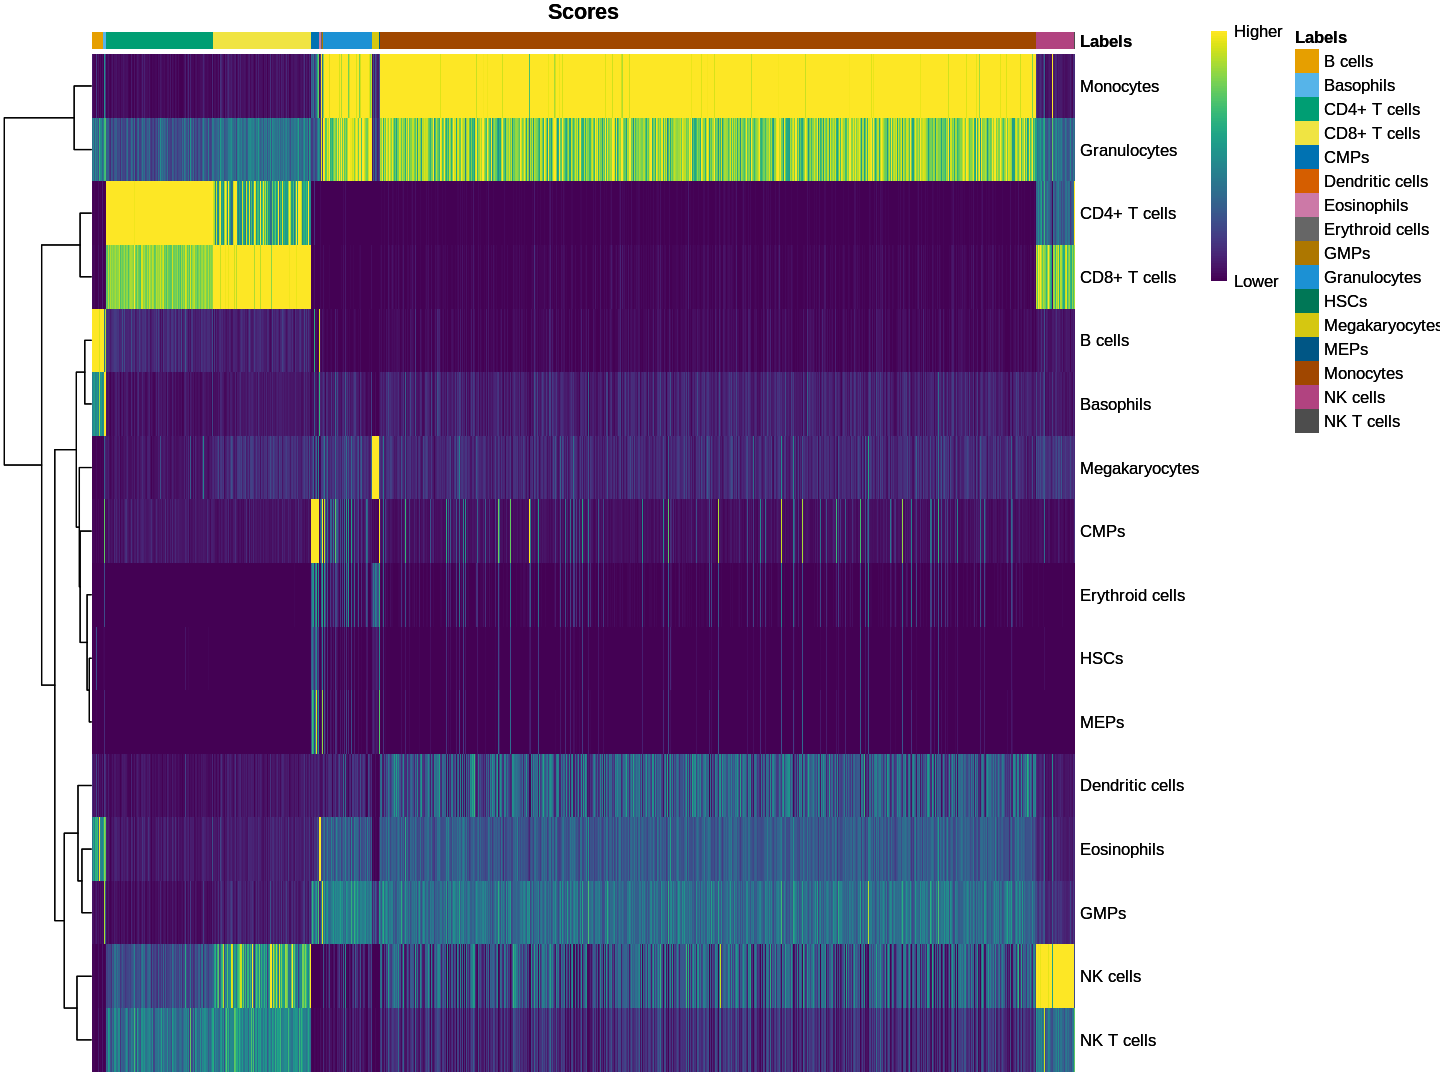

In [45]:
options(repr.plot.height=9,repr.plot.width=12)
plotScoreHeatmap(AL.nhsc)

In [46]:
options(repr.plot.height=9,repr.plot.width=16)

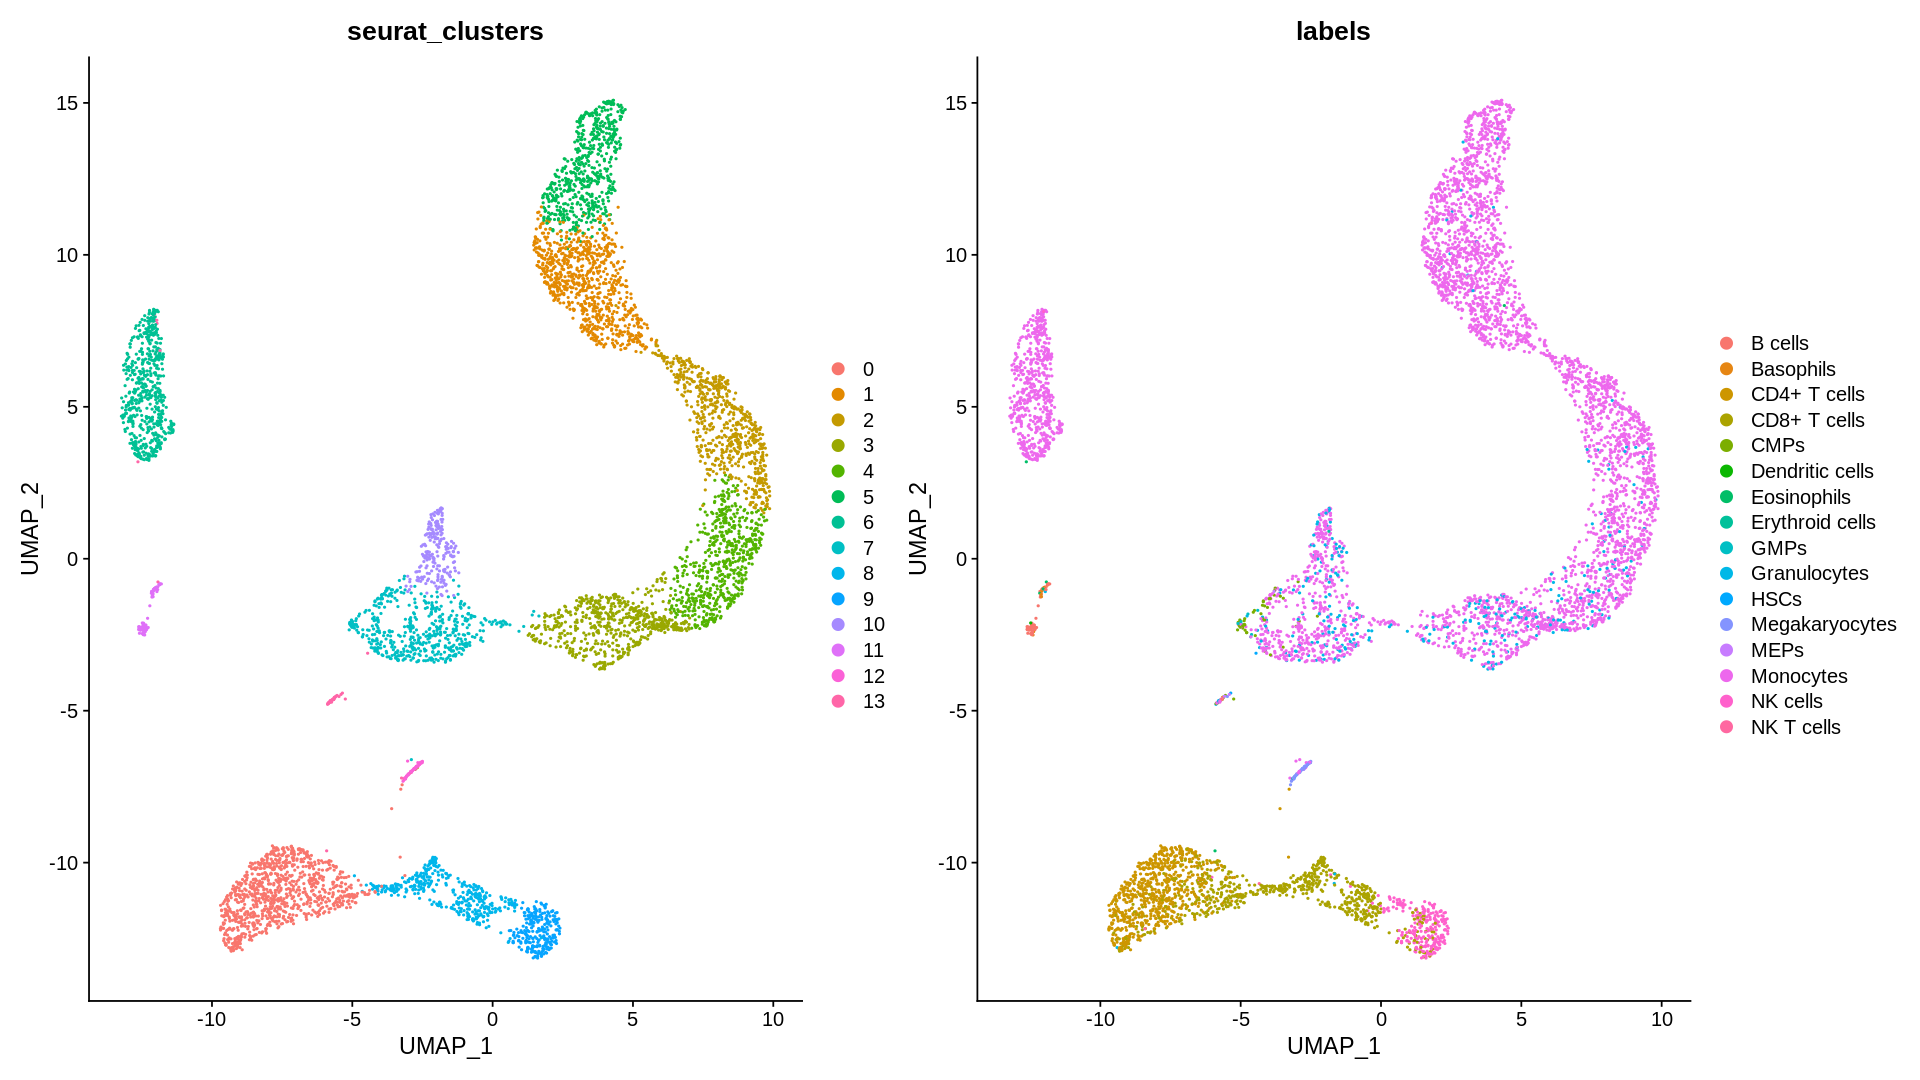

In [47]:
unlabel_plot<-DimPlot(normal2, group.by = c("seurat_clusters","labels"),reduction = "umap")
unlabel_plot

In [48]:
AL.hesc <- SingleR(test = AL_for_SingleR, ref= hpca.se, labels = hpca.se$label.main) 

Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 2”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 26”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 7”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 8”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 2”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 88”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 17”
Warning message:
“Argument 'center' should be

In [49]:
meta=normal2@meta.data
table(AL.hesc$labels,meta$seurat_clusters)
normal2@meta.data$labels <-AL.hesc$labels

                   
                      0   1   2   3   4   5   6   7   8   9  10  11  12  13
  B_cell              0   0   0   0   0   0   0   0   0   0   0  56   0  18
  BM                  0   0   0   0   0   0   0   0   0   0   0   1   0   1
  CMP                 0   0   0   0   0   0   0   0   0   0   0   0   0   3
  Endothelial_cells   0   0   0   0   0   0   0   0   0   0   0   0   0   1
  Epithelial_cells    0   0   0   0   0   0   0   0   0   0   0   0   0   1
  GMP                 0   0   0   0   0   0   0   2   0   0   0   0   0   1
  HSC_-G-CSF          1   4  34   0   3   0   0   1   0   0   0   1   1   0
  Macrophage          0   0   0   0   0   0   0   0   0   0   0   0   0   1
  Monocyte            0   0   0   0   0   0 570   0   0   0   0   0   0   5
  Myelocyte           0   0 408 609 606   0   0  60   0   0 102   1   0   0
  Neutrophils         0 822 205   0   0 590   0   0   0   0   0   0   5   4
  NK_cell             3   0   0   0   0   0   0   0  44 246   0   0 

In [50]:
type<-as.data.frame(AL.hesc$labels)
count<-table(type)
count

type
           B_cell                BM               CMP Endothelial_cells 
               74                 2                 3                 1 
 Epithelial_cells               GMP        HSC_-G-CSF        Macrophage 
                1                 3                45                 1 
         Monocyte         Myelocyte       Neutrophils           NK_cell 
              575              1786              1626               293 
        Platelets  Pre-B_cell_CD34-  Pro-B_cell_CD34+     Pro-Myelocyte 
               47                16                30               568 
          T_cells 
             1285 

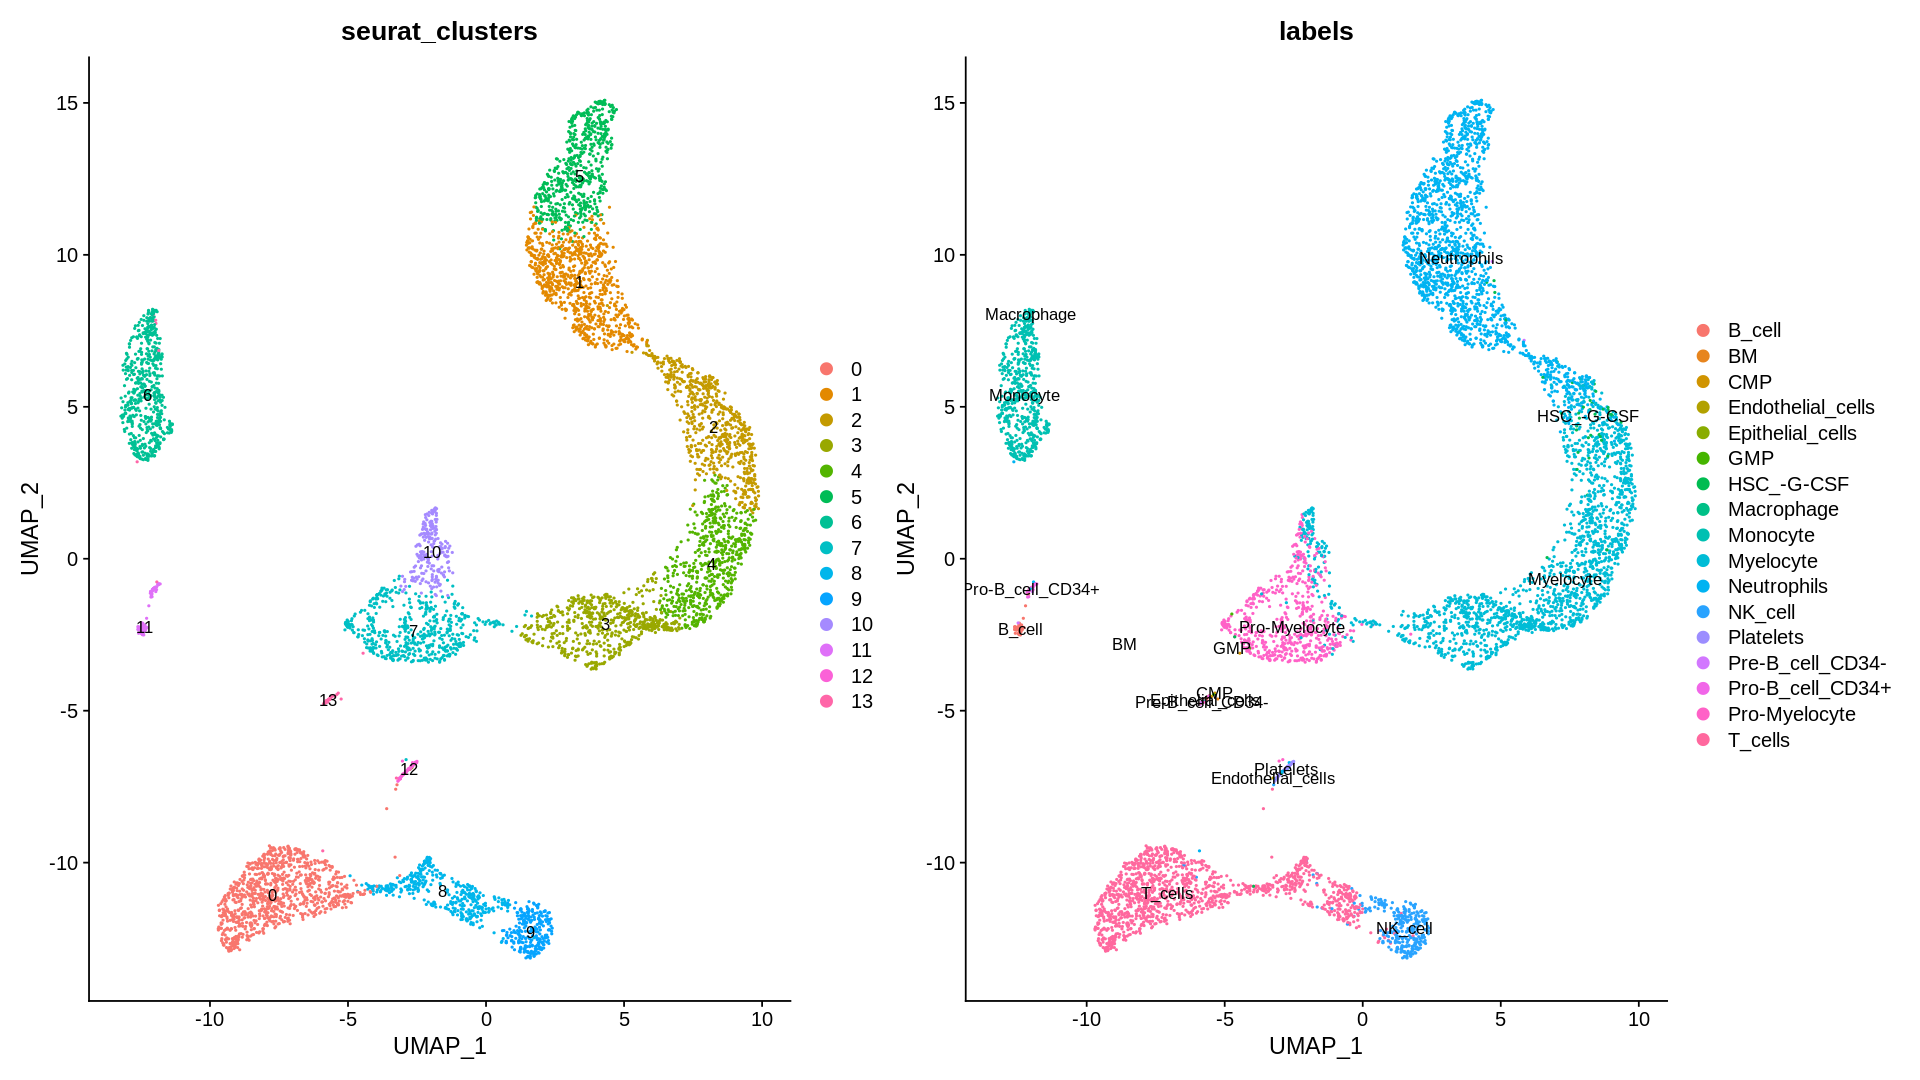

In [51]:
label_plot<-DimPlot(normal2, group.by = c("seurat_clusters","labels"),reduction = "umap",label = TRUE,label.size =3.5)
label_plot

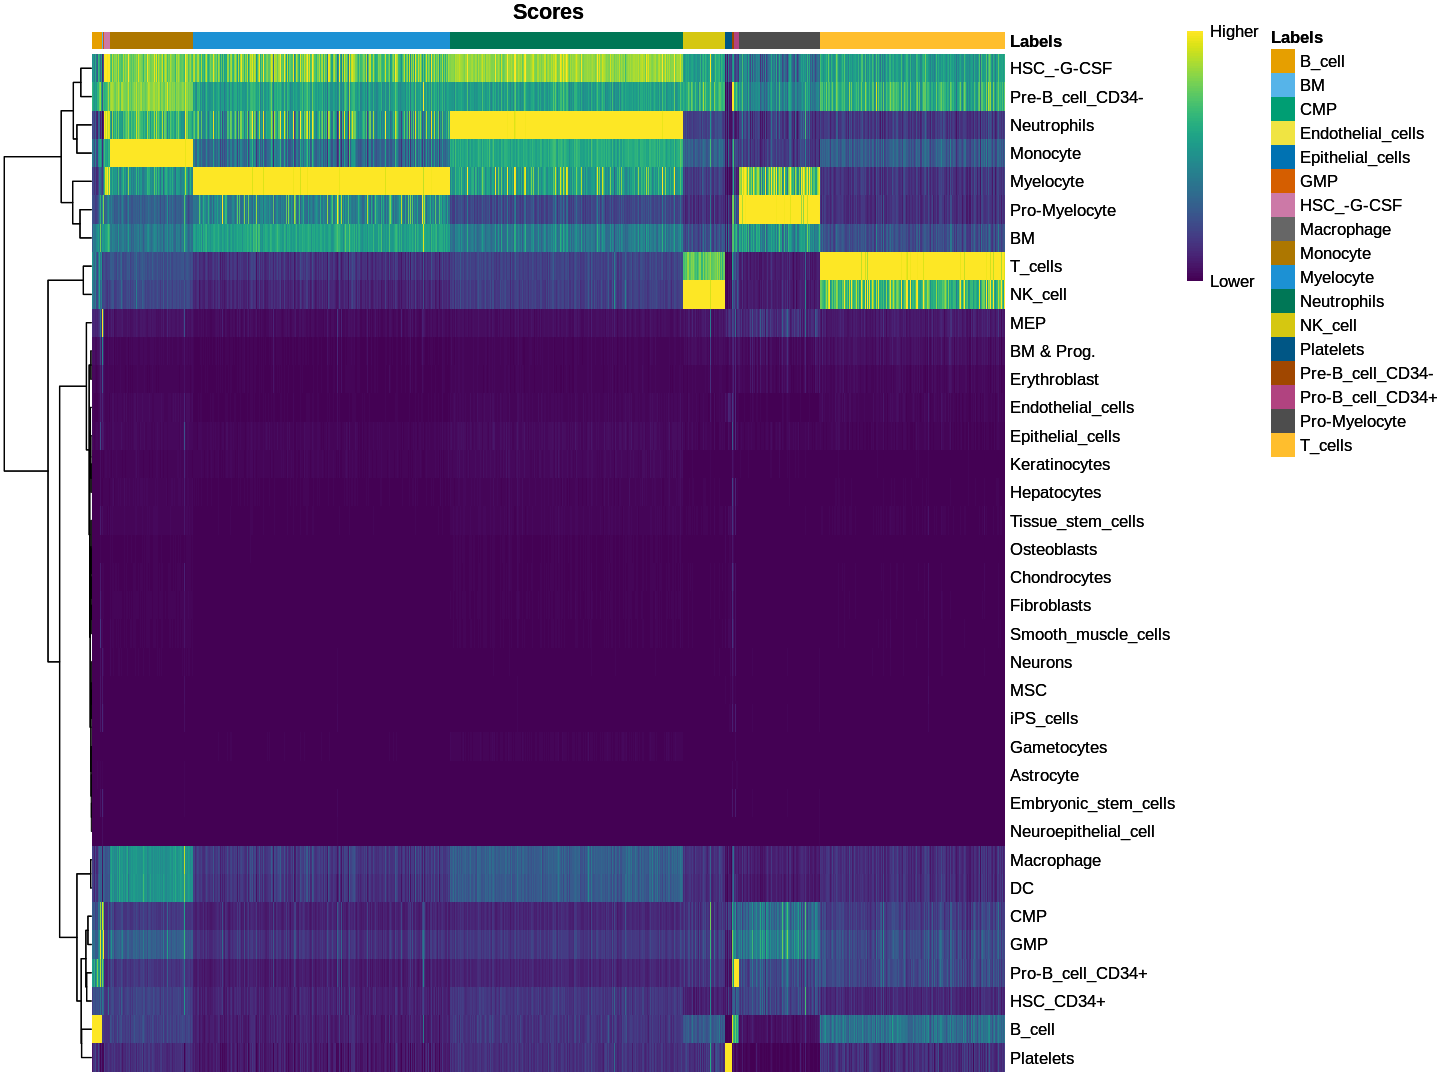

In [52]:
options(repr.plot.height=9,repr.plot.width=12)
plotScoreHeatmap(AL.hesc)

In [53]:
options(repr.plot.height=9,repr.plot.width=16)

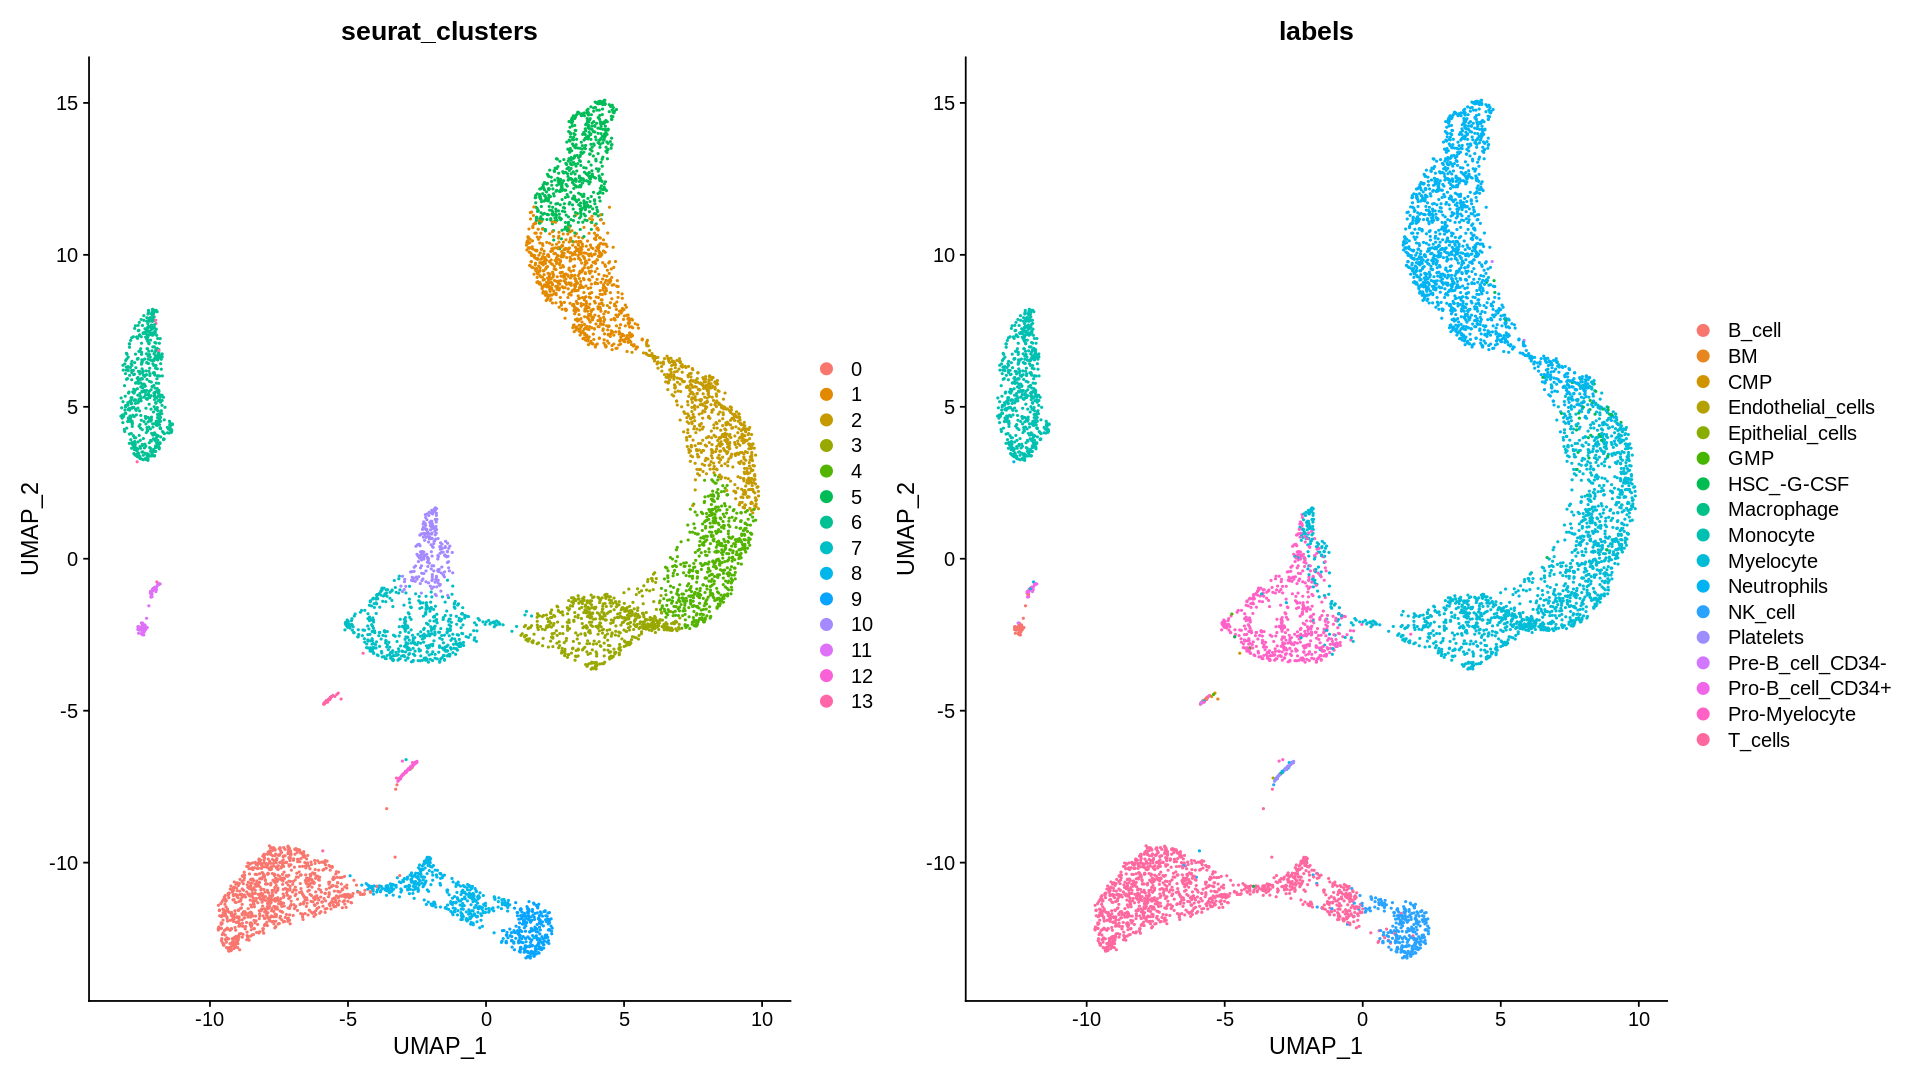

In [54]:
unlabel_plot<-DimPlot(normal2, group.by = c("seurat_clusters","labels"),reduction = "umap")
unlabel_plot

In [55]:
options(repr.plot.height=9,repr.plot.width=7)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



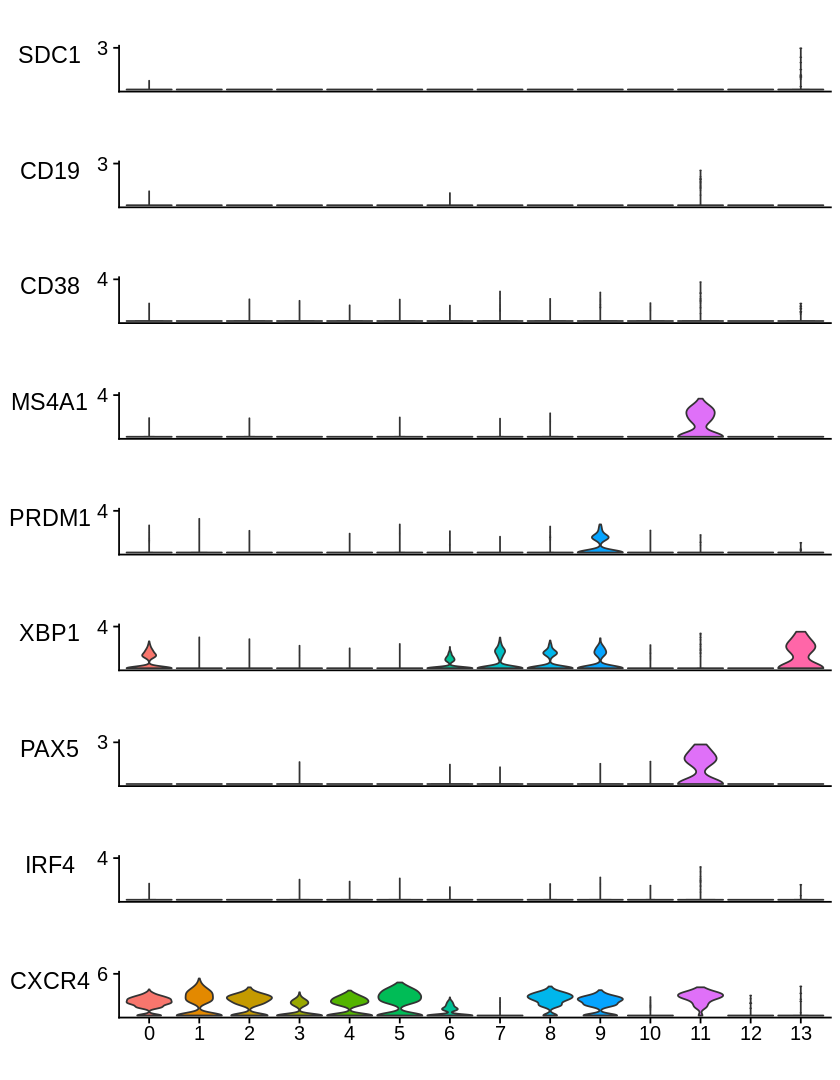

In [56]:
# plasma cell marker
features<- c("SDC1","CD19","CD38","MS4A1","PRDM1","XBP1","PAX5","IRF4","CXCR4")
StackedVlnPlot(obj =normal2, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



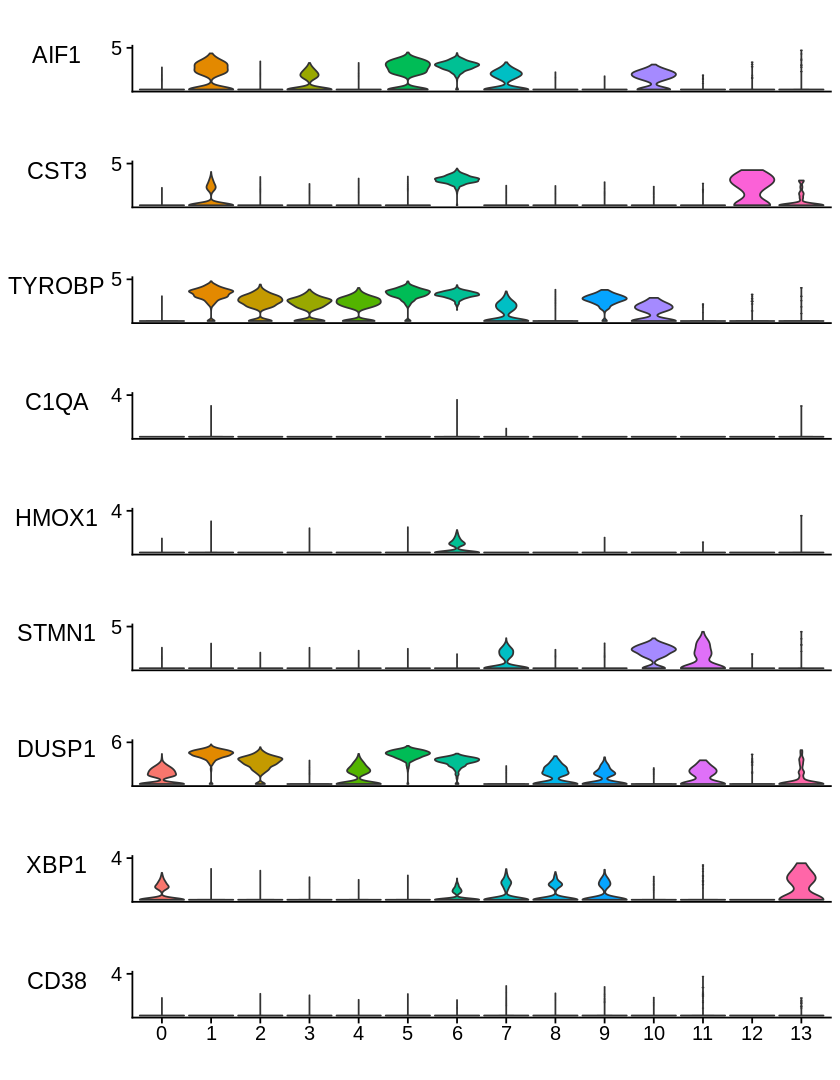

In [57]:
# monocyte?
features<- c("AIF1","CST3","TYROBP","C1QA","HMOX1","STMN1","DUSP1","XBP1","CD38")
StackedVlnPlot(obj =normal2, features = features)

In [58]:
options(repr.plot.height=6,repr.plot.width=6)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



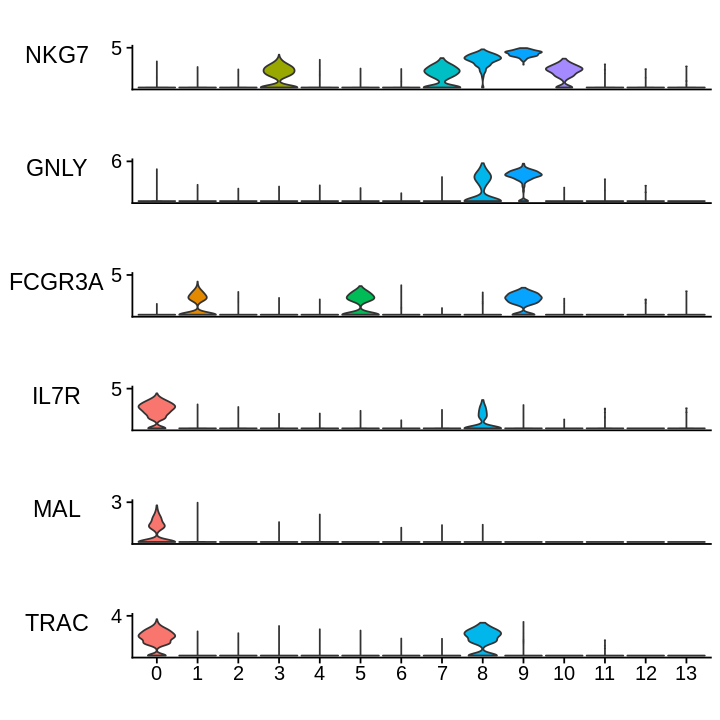

In [59]:
# NK cell
features<- c("NKG7","GNLY","FCGR3A","IL7R","MAL","TRAC")
StackedVlnPlot(obj =normal2, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



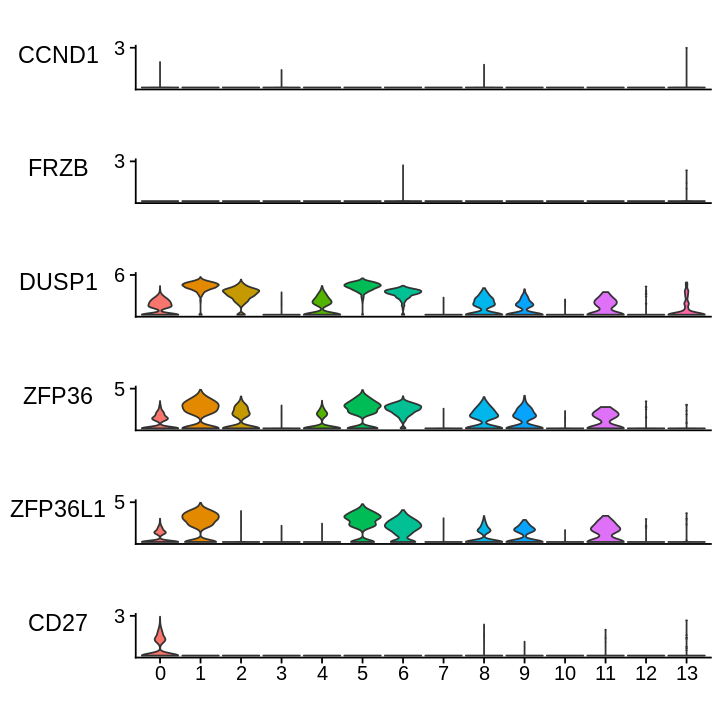

In [60]:
#CCND-dendritic
features<- c("CCND1","FRZB","DUSP1","ZFP36","ZFP36L1","CD27")
StackedVlnPlot(obj =normal2, features = features)

In [61]:
options(repr.plot.height=4,repr.plot.width=8)


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




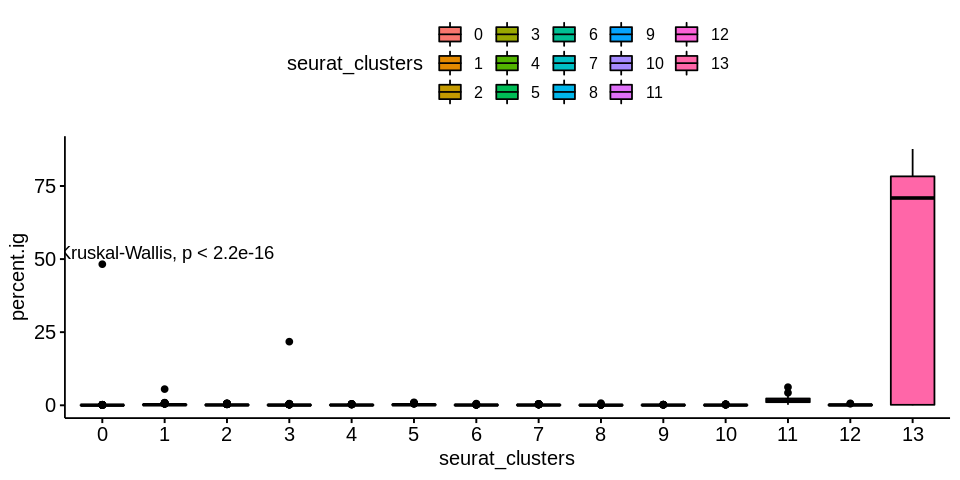

In [62]:
library(ggpubr)
library(RColorBrewer)
ggboxplot(normal2@meta.data, x="seurat_clusters", y="percent.ig", fill = "seurat_clusters")+
  stat_compare_means(label.y = 50)

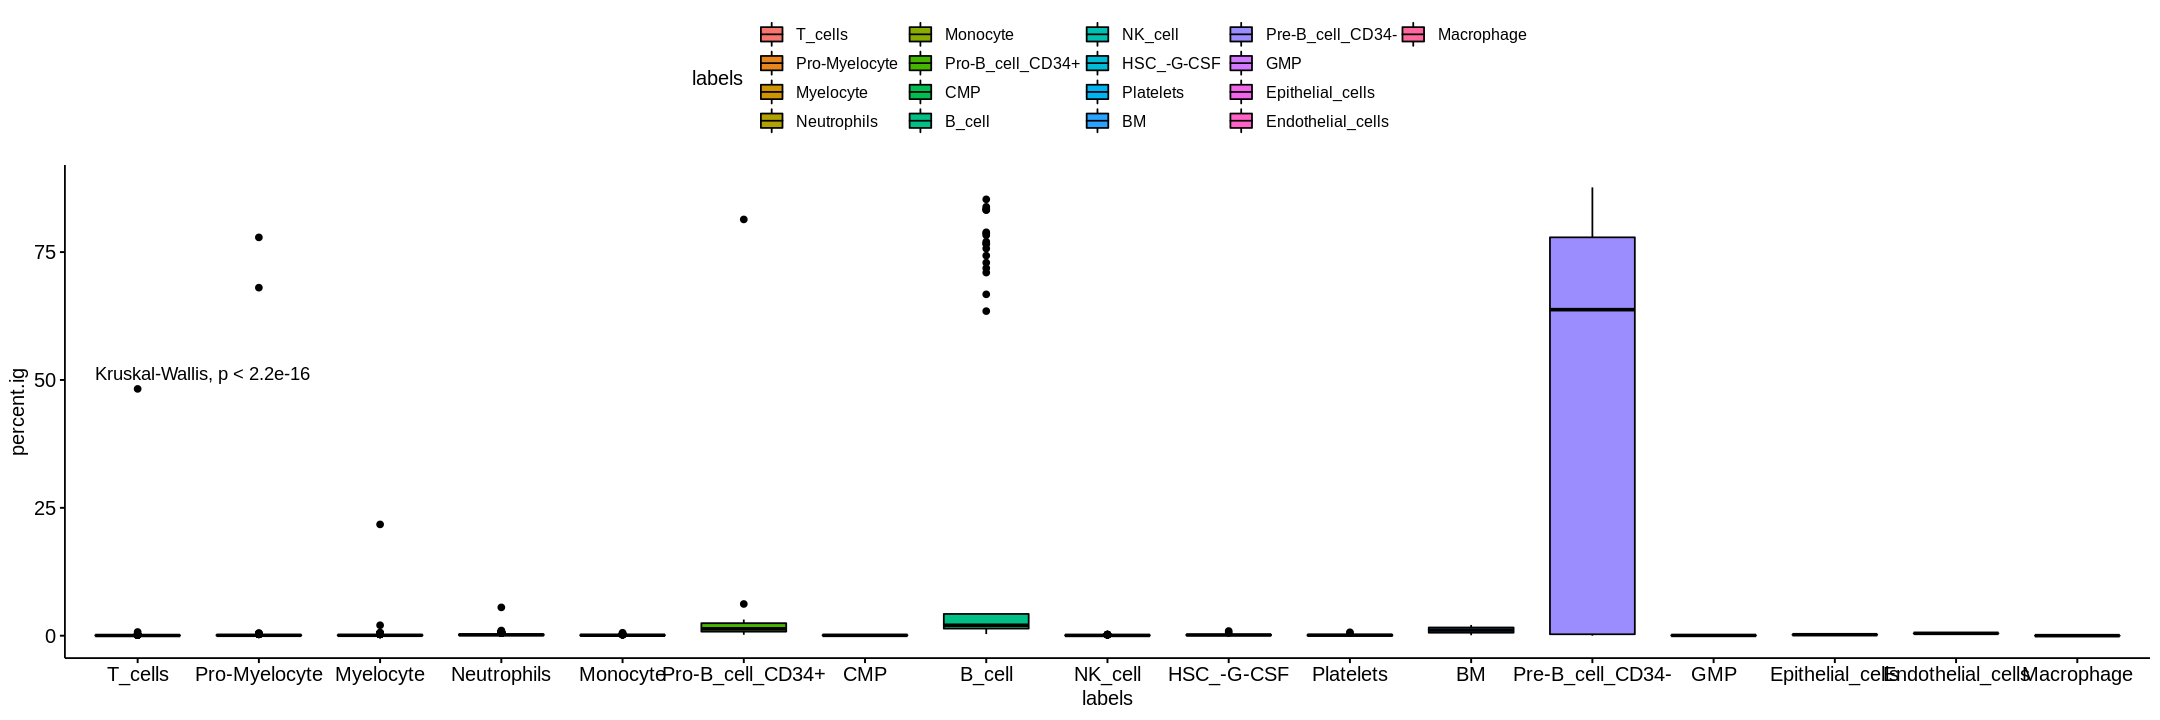

In [63]:
options(repr.plot.height=6,repr.plot.width=18)
ggboxplot(normal2@meta.data, x="labels", y="percent.ig", fill = "labels")+
  stat_compare_means(label.y = 50)

In [64]:
normal3.markers <- FindAllMarkers(normal2, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
normal3.markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13



p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene    
1   0.000000e+00 3.458956   0.882 0.035  0.000000e+00 0       IL7R    
2   0.000000e+00 2.737876   0.981 0.275  0.000000e+00 0       LTB     
3   0.000000e+00 2.635135   0.998 0.604  0.000000e+00 0       RPS18   
4   0.000000e+00 2.551504   0.998 0.821  0.000000e+00 0       RPS27   
5   0.000000e+00 2.541862   0.998 0.534  0.000000e+00 0       RPS21   
6   0.000000e+00 2.911469   0.827 0.131  0.000000e+00 1       CMTM2   
7   0.000000e+00 2.858302   0.842 0.245  0.000000e+00 1       CXCL8   
8   0.000000e+00 2.763429   0.927 0.298  0.000000e+00 1       G0S2    
9   0.000000e+00 2.667391   0.996 0.401  0.000000e+00 1       NAMPT   
10  0.000000e+00 2.624477   0.988 0.237  0.000000e+00 1       FCGR3B  
11  0.000000e+00 3.046061   0.983 0.167  0.000000e+00 2       MMP9    
12  0.000000e+00 2.600429   0.995 0.418  0.000000e+00 2       S100A12 
13 1.264252e-280 2.090576   0.912 0.313 2.567064e-276 2       CKAP4   
14 7.627234e-257 2.147561   0.937 0.494 1.548710e-252 2       HMGB2   
15 2.360225e-227 2.073165   0.702 0.170 4.792437e-223 2       CLC     
16  0.000000e+00 4.813218   0.998 0.229  0.000000e+00 3       CAMP    
17  0.000000e+00 3.952265   1.000 0.259  0.000000e+00 3       LTF     
18  0.000000e+00 3.771808   0.979 0.201  0.000000e+00 3       RETN    
19  0.000000e+00 3.573962   0.995 0.232  0.000000e+00 3       LCN2    
20  0.000000e+00 2.952524   0.807 0.079  0.000000e+00 3       ABCA13  
21  0.000000e+00 2.888511   0.998 0.421  0.000000e+00 4       S100A12 
22  0.000000e+00 2.837766   0.941 0.148  0.000000e+00 4       MMP8    
23  0.000000e+00 2.837060   0.989 0.188  0.000000e+00 4       CRISP3  
24  0.000000e+00 2.583676   0.903 0.181  0.000000e+00 4       MMP9    
25  0.000000e+00 2.443445   0.997 0.303  0.000000e+00 4       PGLYRP1 
26  0.000000e+00 4.047400   0.890 0.094  0.000000e+00 5       IFIT3   
27  0.000000e+00 3.902909   0.790 0.082  0.000000e+00 5       IFIT2   
28  0.000000e+00 3.771359   0.649 0.040  0.000000e+00 5       RSAD2   
29  0.000000e+00 3.461917   0.646 0.039  0.000000e+00 5       IFIT1   
30 6.061628e-306 4.163510   0.825 0.242 1.230814e-301 5       ISG15   
⋮  ⋮             ⋮          ⋮     ⋮     ⋮             ⋮       ⋮       
41  0.000000e+00 3.636551   0.987 0.094  0.000000e+00 8       CCL5    
42  0.000000e+00 3.194630   0.743 0.071  0.000000e+00 8       CCL4    
43  0.000000e+00 3.120551   0.977 0.081  0.000000e+00 8       GZMA    
44  0.000000e+00 3.115606   0.600 0.033  0.000000e+00 8       GZMK    
45 7.735176e-175 2.804514   0.462 0.057 1.570627e-170 8       GNLY    
46  0.000000e+00 4.475626   0.922 0.047  0.000000e+00 9       GNLY    
47  0.000000e+00 3.868607   0.949 0.022  0.000000e+00 9       GZMB    
48  0.000000e+00 3.839609   0.930 0.028  0.000000e+00 9       FGFBP2  
49  0.000000e+00 3.452605   0.938 0.044  0.000000e+00 9       PRF1    
50 5.192723e-237 3.887754   1.000 0.271 1.054382e-232 9       NKG7    
51  0.000000e+00 2.811451   0.737 0.017  0.000000e+00 10      MKI67   
52 1.541450e-200 2.975953   0.837 0.115 3.129914e-196 10      DEFA4   
53 4.648028e-175 3.654156   0.990 0.259 9.437820e-171 10      DEFA3   
54 1.149902e-171 3.172214   0.914 0.212 2.334877e-167 10      TUBB    
55 1.280933e-140 4.064380   0.842 0.224 2.600934e-136 10      HIST1H4C
56  0.000000e+00 4.632058   0.865 0.011  0.000000e+00 11      IGHM    
57  0.000000e+00 4.144373   0.809 0.002  0.000000e+00 11      VPREB3  
58  0.000000e+00 4.137131   0.854 0.025  0.000000e+00 11      CD79B   
59  0.000000e+00 3.763602   0.596 0.001  0.000000e+00 11      TCL1A   
60 7.928224e-127 3.866694   1.000 0.159 1.609826e-122 11      HLA-DRA 
61  0.000000e+00 6.466326   1.000 0.025  0.000000e+00 12      GNG11   
62 4.274020e-296 7.674220   1.000 0.033 8.678398e-292 12      PF4     
63 2.107585e-168 6.899959   1.000 0.068 4.279452e-164 12      GP1BB   
64 1.342363e-164 8.319503   1.000 0.070 2.725668e-160 12      PPBP    
65 8.392503e-148 6.292075  

In [65]:
options(repr.plot.height=10,repr.plot.width=10)

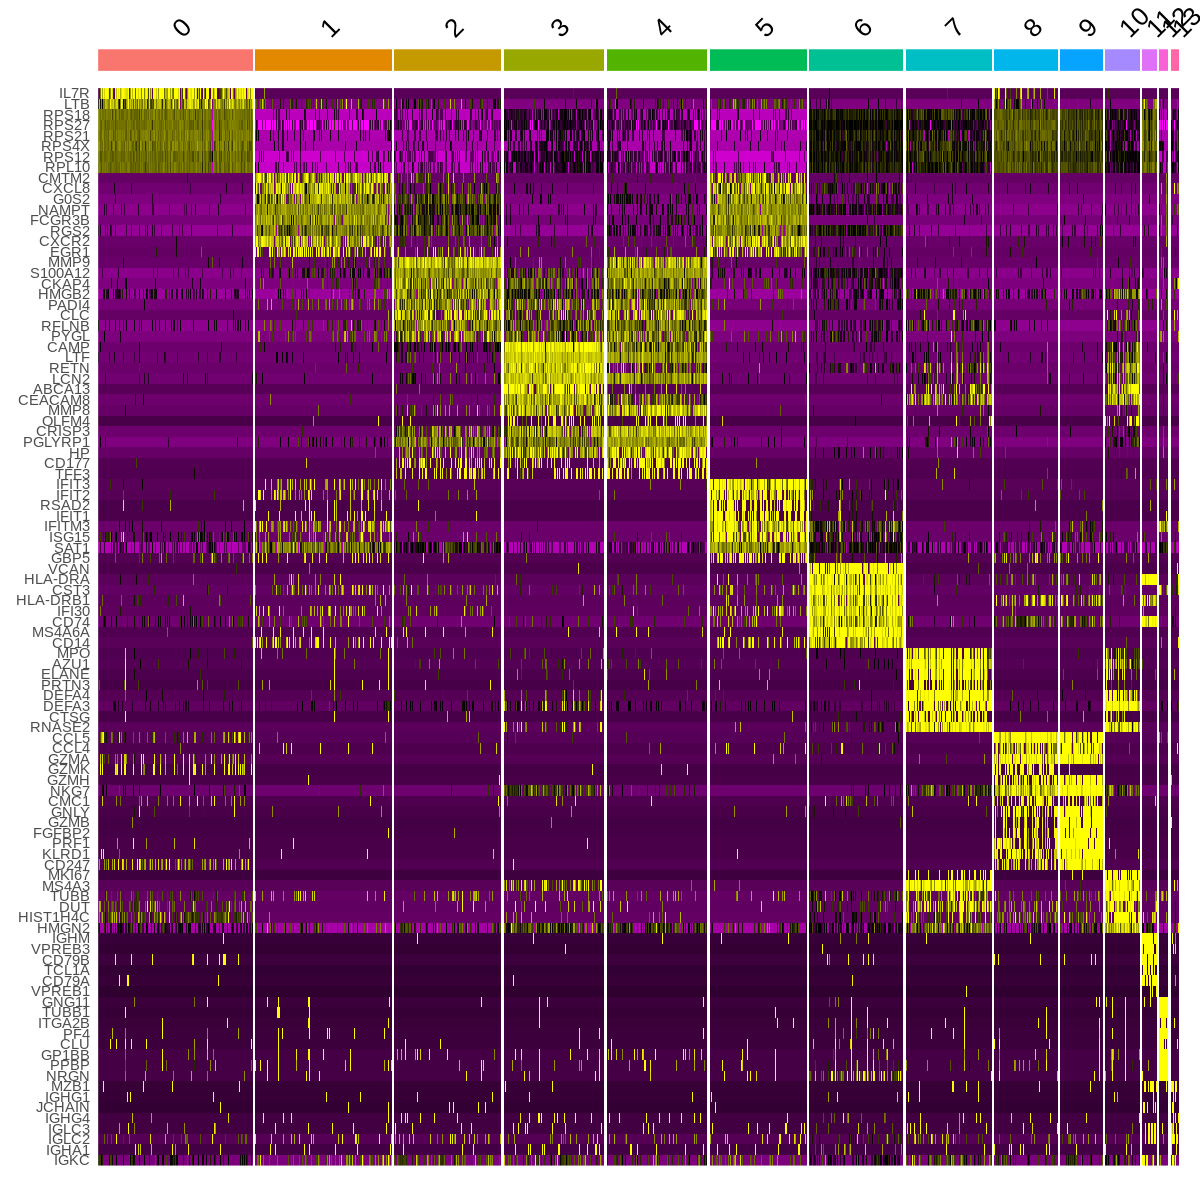

In [66]:
top10 <- normal3.markers %>% group_by(cluster) %>% top_n(n = 8, wt = avg_log2FC)
DoHeatmap(normal2, features = top10$gene) + NoLegend()

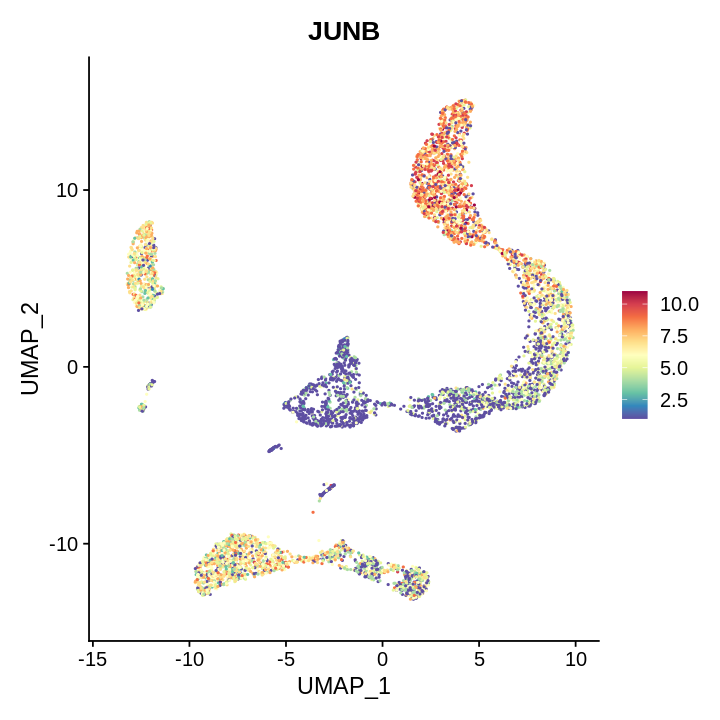

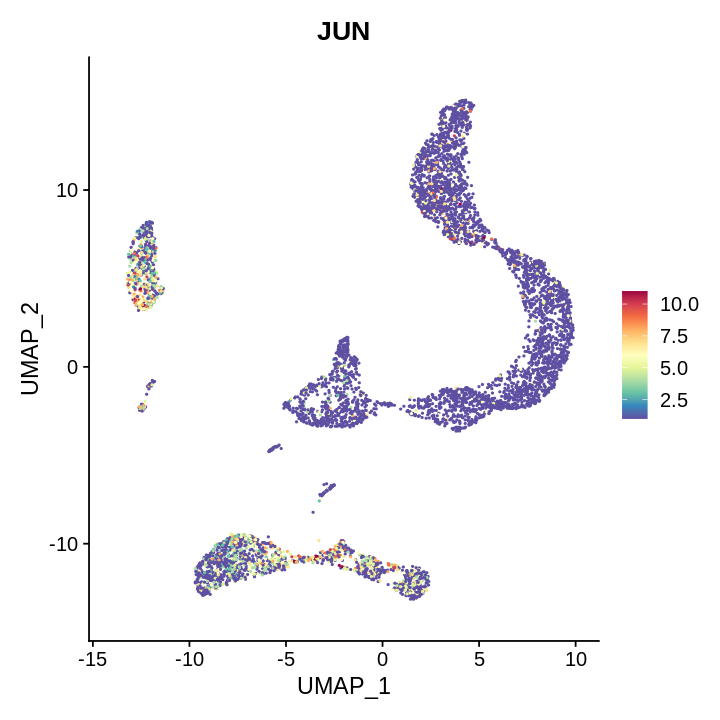

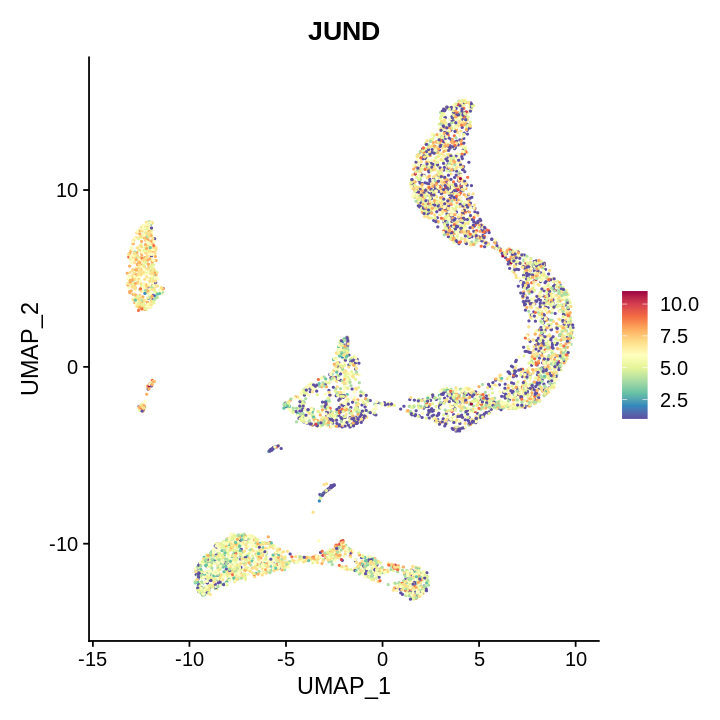

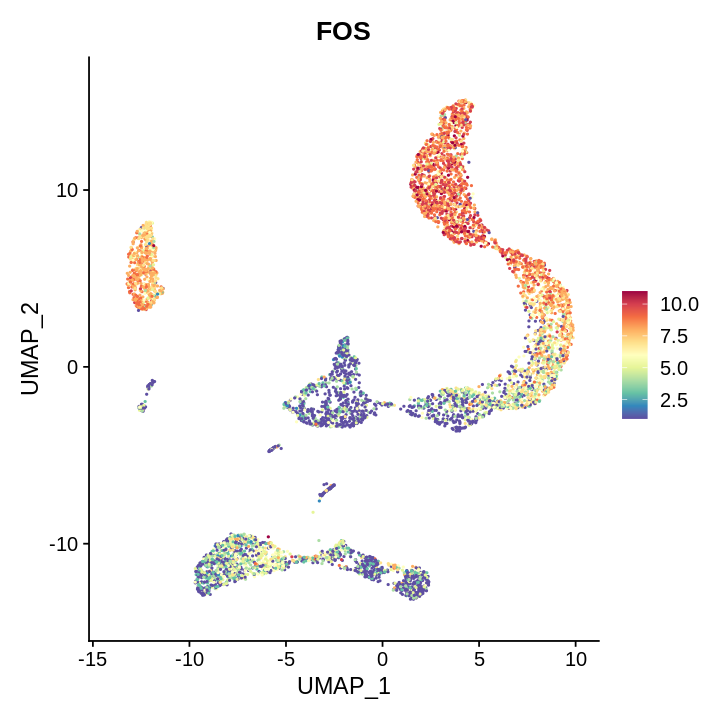

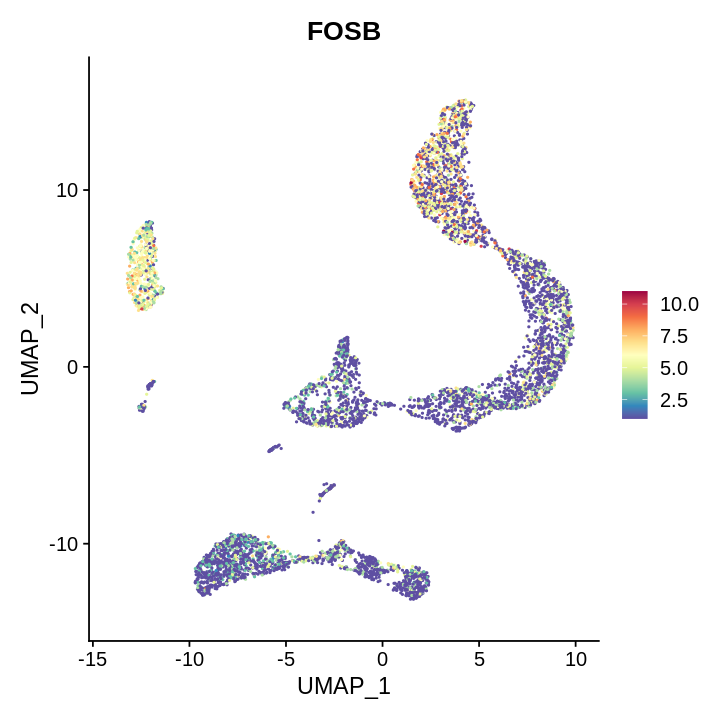

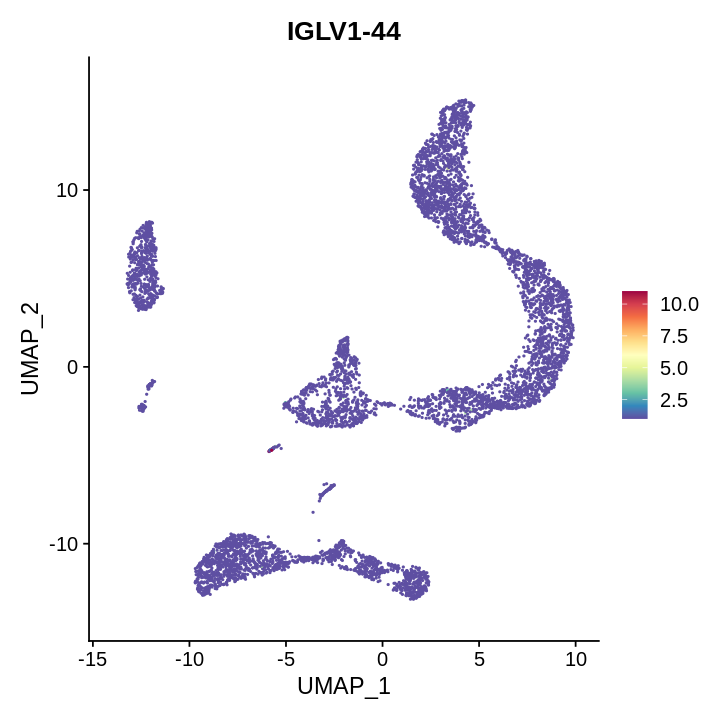

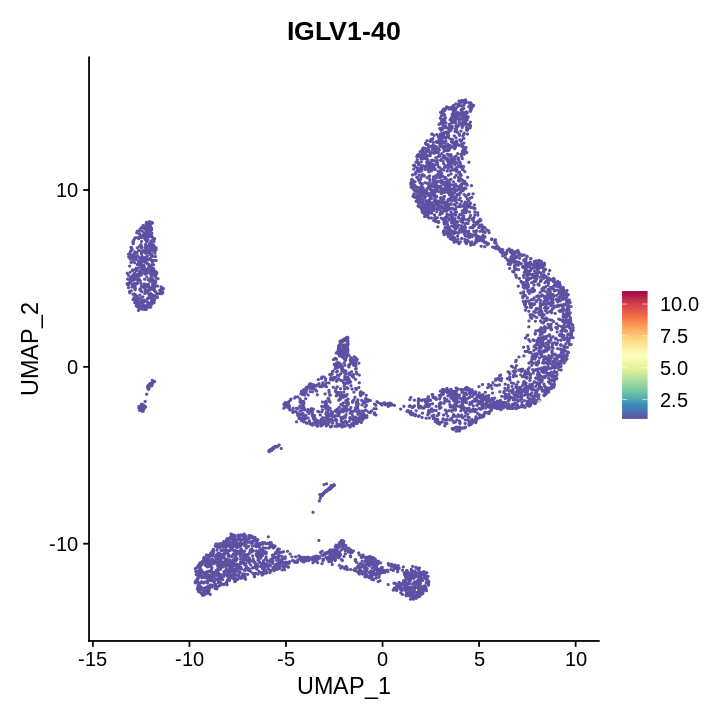

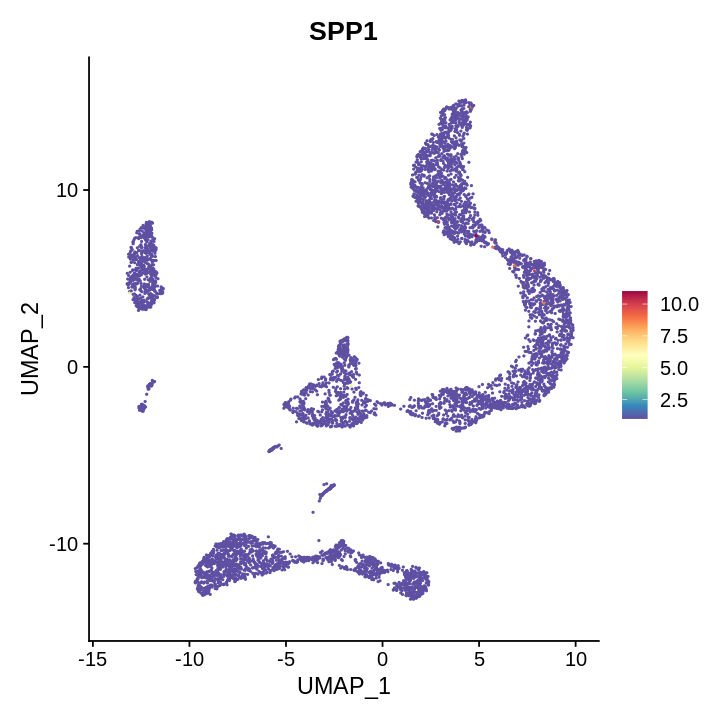

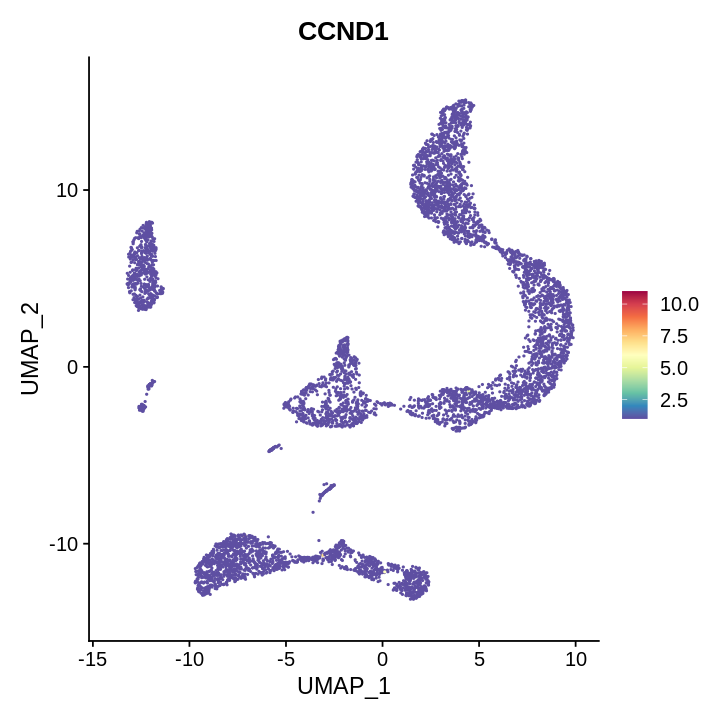

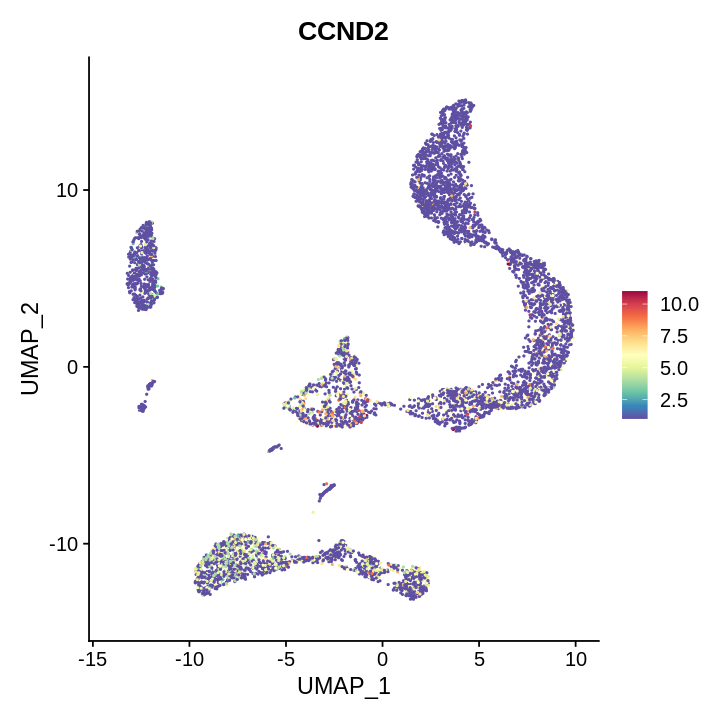

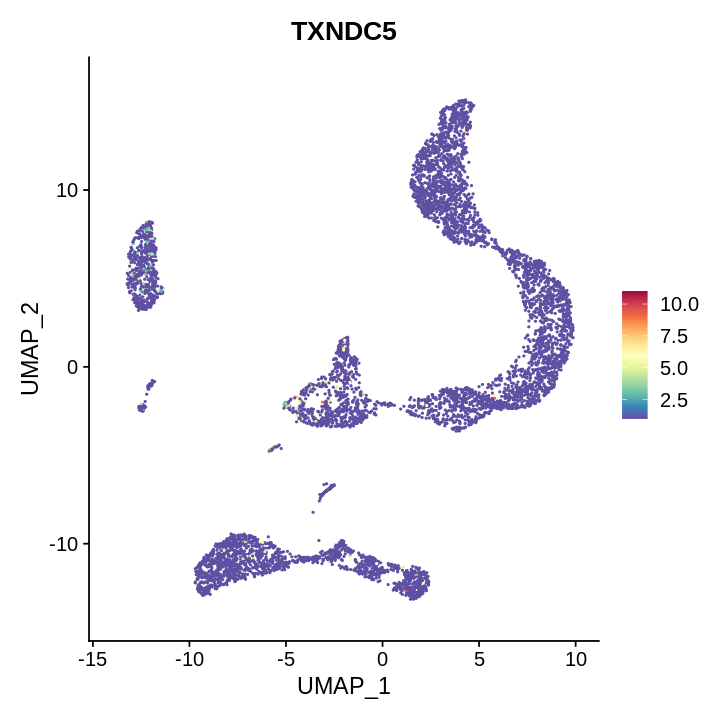

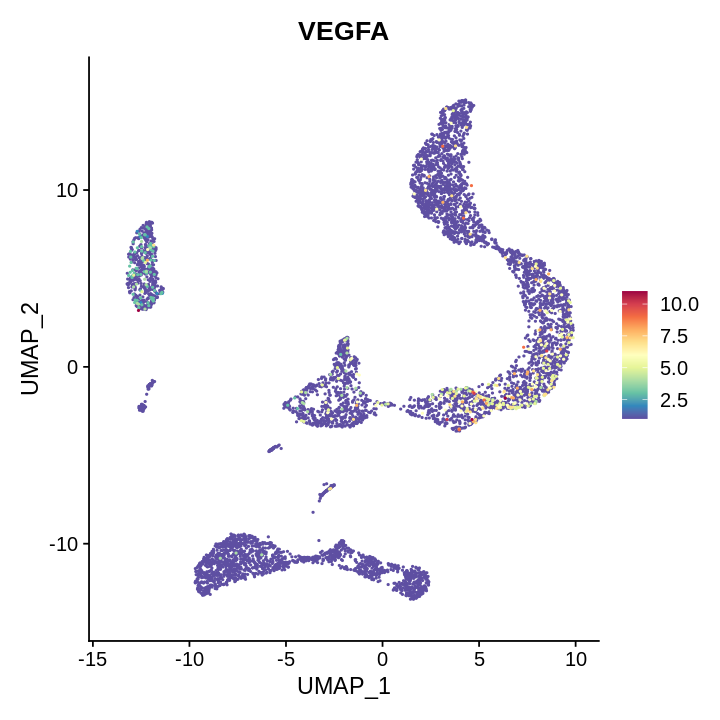

In [68]:
options(repr.plot.height=6,repr.plot.width=6)
FeaturePlot(normal2, features = c('JUNB'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('JUN'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('JUND'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('FOS'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('FOSB'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('IGLV1-44'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('IGLV1-40'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('SPP1'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('CCND1'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('CCND2'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('TXNDC5'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('VEGFA'),order=TRUE,cols=rev(brewer.pal(11,'Spectral')))

In [ ]:
save(normal2,file="0819-POEMS13-3.Rda")

In [ ]:
normal2